# This notebook is used to evaluate the total flux and luminosity of each HII regions, while taking into account the diffuse background emission and the limits of a regions using the Halpha flux profile of this region. The FWHM/2 of the Halpha profile is also defined and used has an indicator of the size of the regions (Strömgren radius).

# Starting point if the files noest exist:  see below

In [30]:
# Import Libraries
import matplotlib
matplotlib.use('TkAgg')
from matplotlib import rc
import matplotlib.pyplot as plt
from astropy.io import fits
import numpy as np
import scipy
from scipy import ndimage
from matplotlib.lines import Line2D
from pylab import *
from scipy.optimize import curve_fit
from scipy import asarray as ar,exp
from numpy import sqrt, pi, exp, loadtxt
from lmfit import Model
from copy import deepcopy
from scipy.optimize import minimize
from lmfit.models import PseudoVoigtModel
from lmfit.models import LinearModel

//anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:1350: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [31]:
# Read files

# Halpha maximal intensity
ahdu_list1 = fits.open('NGC628_SN3_1.0.LineMaps.map.6563.amplitude.clean.fits')
ahdu_list1.info()
aimage_data1 = ahdu_list1[0].data
ahdu_list1.close()

# Halpha FWHM in nm
fhdu_list1 = fits.open('NGC628_SN3_1.0.LineMaps.map.6563.fwhm.clean.fits')
fhdu_list1.info()
fimage_data1 = fhdu_list1[0].data
fhdu_list1.close()

# HIIR peak position
regxy = np.loadtxt('Region_xy_centroid.reg')
regx = regxy[0:,0]
regy = regxy[0:,1]

# HIIR pixels distance from the peak
dis= fits.open('NGC628_distance_grow.fits')
dis.info()
d = dis[0].data
dis.close()

# HIIR ID mask
gr= fits.open('NGC628_HIIPhot3_All_GROW.fits')
gr.info()
grow = gr[0].data
gr.close()

# Halpha flux extinction corrected
flux22 = fits.open('NGC628_SN3_1.0.LineMaps.map.6563.flux.extcor.clean.int33i.fits')
flux22.info()
flux2 = flux22[0].data/(1.20671)**2 
flux22.close()

print 'number of region = ',  len(regx)

Filename: NGC628_SN3_1.0.LineMaps.map.6563.amplitude.clean.fits
No.    Name         Type      Cards   Dimensions   Format
0    PRIMARY     PrimaryHDU      71   (2048, 2064)   float32   
Filename: NGC628_SN3_1.0.LineMaps.map.6563.fwhm.clean.fits
No.    Name         Type      Cards   Dimensions   Format
0    PRIMARY     PrimaryHDU      71   (2048, 2064)   float32   
Filename: NGC628_distance_grow.fits
No.    Name         Type      Cards   Dimensions   Format
0    PRIMARY     PrimaryHDU       9   (2048, 2064)   float32   
Filename: NGC628_HIIPhot3_All_GROW.fits
No.    Name         Type      Cards   Dimensions   Format
0    PRIMARY     PrimaryHDU      71   (2048, 2064)   float32   
Filename: NGC628_SN3_1.0.LineMaps.map.6563.flux.extcor.clean.int33i.fits
No.    Name         Type      Cards   Dimensions   Format
0    PRIMARY     PrimaryHDU       9   (2048, 2064)   float64   
number of region =  4285


In [32]:
#Halpha flux from the sinc function line profile : F = Maximal intensity * FWHM [A] / 1.20671

flux = aimage_data1*fimage_data1*10/1.20671 
flux[(np.isfinite(flux) == False)] = 0 # remove Nan values
flux2[(np.isfinite(flux2) == False)] = 0 # remove Nan values

In [33]:
# Define the total flux (flux_tot), the limits (lim) and the background emission (med) à
# of each regions from the Halpha profile
######## Take a few minutes ########

flux_central=np.zeros(len(regx))
flux_tot=np.zeros(len(regx))
flux_tot2=np.zeros(len(regx))

n = 16
fl = np.zeros(n)
dl = np.zeros(n)
t = np.zeros(n)
tt = np.zeros(n)
t[0:16] = 500
tt[0:16] = 500
lim = np.zeros(len(regx))
med = np.zeros(len(regx))
med2 = np.zeros(len(regx))

for i in range(0,len(regx)) : 
    
    m = np.max(d[(grow == i+1)])
    dist = np.array(len(np.where(grow == i+1)[0]))
    flux_prof = np.array(len(np.where(grow == i+1)[0]))
    flux_prof2 = np.array(len(np.where(grow == i+1)[0]))

    xxyy=np.where(grow == i+1)
    dist=d[xxyy[0],xxyy[1]]
    flux_prof=flux[xxyy[0],xxyy[1]]
    flux_prof2=flux2[xxyy[0],xxyy[1]]
    maxi = np.mean(flux_prof[(dist < np.min(dist)+5)])

    xx = np.where((flux_prof/maxi > 0.6) & (dist > 100)) 
    flux_prof[xx] = -10
    xx = np.where((flux_prof/maxi > 1.2) & (dist > 10)) 
    flux_prof[xx] = -10

    distt = dist[(flux_prof > -9)]
    flux_proff = np.array(len(np.where(flux_prof > -9)[0]))
    flux_proff2 = np.array(len(np.where(flux_prof > -9)[0]))

    flux_proff = flux_prof[(flux_prof > -9)]
    flux_proff2 = flux_prof2[(flux_prof > -9)]
    flux_prof=flux[xxyy[0],xxyy[1]]
    flux_prof2=flux2[xxyy[0],xxyy[1]]
    
    mm = np.max(flux_prof)
    dm = np.max(dist)
    mi = (np.median(flux_prof[(dist > dm-100)]))/mm
    if mi < 0 :
        mi = 0

    t[0:16] = 500
    tt[0:16] = 500    
    
    for j in range(0,n) :
        fl[j]= np.median(flux_prof[(dist < j*25+25)])/mm-mi
        dl[j] = j*25+12.5
        
        if j > 0 and j < 15  : 
            t[j] = fl[j-1]-fl[j]
        if j > 0 and j < 15 : 
            tt[j] = fl[j-1]-fl[j+1]

    if len(dl[(t < 0.025) & (tt < 0.15)]) == 1 :
        lim[i] = dl[(t < 0.025) & (tt < 0.15)]
    if len(dl[(t < 0.025) & (tt < 0.15)]) == 0 :
        lim[i] = m
    if len(dl[(t < 0.025) & (tt < 0.15)]) > 1 :
        lim[i] = dl[(t < 0.025) & (tt < 0.15)][0]
    if lim[i] > m :
        lim[i] = m
    if lim[i] < 100 and m > 100 :
        lim[i] = 100
    if lim[i] < 100 and m < 100 :
        lim[i] = m-5
    if lim[i] > 300 :
        lim[i] = 300
    #if dm < 250 :
    #    lim[i] = dm
    
    flux_central[i] = np.mean(flux[round(regy[i])-3:round(regy[i])+1,\
                                   round(regx[i])-3:round(regx[i])+1])
#    if not lim[i] == m :
    med[i] = np.median(flux_proff[(distt > lim[i]-5) & (distt < lim[i]+35)])
    med2[i] = np.median(flux_proff2[(distt > lim[i]-5) & (distt < lim[i]+35)])
    if med[i]/mm > 0.5 : 
         med[i] = mm*0.3
    flux_tot[i] = np.sum(flux_prof[(dist < lim[i])])\
                   -len(np.where(dist < lim[i])[0])*\
                   med[i]
    if med2[i]/mm > 0.5 : 
         med2[i] = mm*0.3
    flux_tot2[i] = np.sum(flux_prof2[(dist < lim[i])])\
                   -len(np.where(dist < lim[i])[0])*\
                   med2[i]
#    else :
#        med[i] = np.median(flux[(grow == i+1) & (d > lim[i]-25)])
#        med2[i] = np.median(flux2[(grow == i+1) & (d > lim[i]-25)])
#
#        if med[i]/mm > 0.5 : 
#            med[i] = mm*0.3
#        flux_tot[i] = np.sum(flux[(grow == i+1) & (d < lim[i])])-\
#                    len(np.where((grow == i+1) & (d < lim[i]))[1])*med[i]
#        if med2[i]/mm > 0.5 : 
#            med2[i] = mm*0.3
#        flux_tot2[i] = np.sum(flux2[(grow == i+1) & (d < lim[i])])-\
#                    len(np.where((grow == i+1) & (d < lim[i]))[1])*med2[i]
#  
# Write files
fits.writeto('NGC628_dimension_regions.fits', lim, clobber=True)
fits.writeto('NGC628_background.regions.fits', med, clobber=True)
fits.writeto('NGC628_background.regions2.fits', med2, clobber=True)
fits.writeto('NGC628_flux_tot_regions.fits', flux_tot, clobber=True)
fits.writeto('NGC628_flux_tot_regions2.fits', flux_tot2, clobber=True)

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:82: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [5]:
# Define the total flux (flux_tot), the limits (lim) and the background emission (med) à
# of each regions from the Halpha profile
######## Take a few minutes ########

flux_central=np.zeros(len(regx))
flux_tot=np.zeros(len(regx))
flux_tot2=np.zeros(len(regx))

n = 16
fl = np.zeros(n)
dl = np.zeros(n)
t = np.zeros(n)
tt = np.zeros(n)
t[0:16] = 500
tt[0:16] = 500
lim = np.zeros(len(regx))
med = np.zeros(len(regx))
med2 = np.zeros(len(regx))

for i in range(0,len(regx)) : 
    
        m = np.max(d[(grow == i+1)])
    dist = np.array(len(np.where(grow == i+1)[0]))
    flux_prof = np.array(len(np.where(grow == i+1)[0]))
    flux_prof2 = np.array(len(np.where(grow == i+1)[0]))

    xxyy=np.where(grow == i+1)
    dist=d[xxyy[0],xxyy[1]]
    flux_prof=flux[xxyy[0],xxyy[1]]
    flux_prof2=flux2[xxyy[0],xxyy[1]]
    maxi = np.mean(flux_prof[(dist < np.min(dist)+5)])

    xx = np.where((flux_prof/maxi > 0.6) & (dist > 100)) 
    flux_prof[xx] = -10
    xx = np.where((flux_prof/maxi > 1.2) & (dist > 10)) 
    flux_prof[xx] = -10

    distt = dist[(flux_prof > -9)]
    flux_proff = np.array(len(np.where(flux_prof > -9)[0]))
    flux_proff2 = np.array(len(np.where(flux_prof > -9)[0]))

    flux_proff = flux_prof[(flux_prof > -9)]
    flux_proff2 = flux_prof2[(flux_prof > -9)]
    flux_prof=flux[xxyy[0],xxyy[1]]
    flux_prof2=flux2[xxyy[0],xxyy[1]]
    
    mm = np.max(flux_proff)
    dm = np.max(distt)
    mi = (np.median(flux_proff[(distt > dm-100)]))/mm
    if mi < 0 :
        mi = 0

    t[0:16] = 500
    tt[0:16] = 500    
    
    for j in range(0,n) :
        fl[j]= np.median(flux_proff[(distt < j*25+25)])/mm-mi
        dl[j] = j*25+12.5
    
    for j in range(1,15) :

        t[j] = fl[j-1]-fl[j]
        tt[j] = fl[j-1]-fl[j+1]

    if len(dl[(t < 0.025) & (tt < 0.2)]) == 1 :
        lim[i] = dl[(t < 0.025) & (tt < 0.2)]
    if len(dl[(t < 0.025) & (tt < 0.2)]) == 0 :
        lim[i] = m
    if len(dl[(t < 0.025) & (tt < 0.2)]) > 1 :
        lim[i] = dl[(t < 0.025) & (tt < 0.2)][0]
    if lim[i] > m :
        lim[i] = m
    if lim[i] < 100 and m > 100 :
        lim[i] = 100
    if lim[i] < 100 and m < 100 :
        lim[i] = m-5
    if lim[i] > 300 :
        lim[i] = 300
    #if dm < 250 :
    #    lim[i] = dm
    
    #flux_central[i] = np.mean(flux[round(regy[i])-3:round(regy[i])+1,\
    #                               round(regx[i])-3:round(regx[i])+1])
#    if not lim[i] == m :
    med[i] = np.median(flux_proff[(distt > lim[i]-5) & (distt < lim[i]+35)])
    med2[i] = np.median(flux_proff2[(distt > lim[i]-5) & (distt < lim[i]+35)])
    if med[i]/mm > 0.5 : 
         med[i] = mm*0.3
    flux_tot[i] = np.sum(flux_prof[(dist < lim[i])])\
                   -len(np.where(dist < lim[i])[0])*\
                   med[i]
    if med2[i]/mm > 0.5 : 
         med2[i] = mm*0.3
    flux_tot2[i] = np.sum(flux_prof2[(dist < lim[i])])\
                   -len(np.where(dist < lim[i])[0])*\
                   med2[i]
#    else :
#        med[i] = np.median(flux[(grow == i+1) & (d > lim[i]-25)])
#        med2[i] = np.median(flux2[(grow == i+1) & (d > lim[i]-25)])
#
#        if med[i]/mm > 0.5 : 
#            med[i] = mm*0.3
#        flux_tot[i] = np.sum(flux[(grow == i+1) & (d < lim[i])])-\
#                    len(np.where((grow == i+1) & (d < lim[i]))[1])*med[i]
#        if med2[i]/mm > 0.5 : 
#            med2[i] = mm*0.3
#        flux_tot2[i] = np.sum(flux2[(grow == i+1) & (d < lim[i])])-\
#                    len(np.where((grow == i+1) & (d < lim[i]))[1])*med2[i]
#  
# Write files
fits.writeto('NGC628_dimension_regions.fits', lim, clobber=True)
fits.writeto('NGC628_background.regions.fits', med, clobber=True)
fits.writeto('NGC628_background.regions2.fits', med2, clobber=True)
fits.writeto('NGC628_flux_tot_regions.fits', flux_tot, clobber=True)
fits.writeto('NGC628_flux_tot_regions2.fits', flux_tot2, clobber=True)

IndentationError: unindent does not match any outer indentation level (<ipython-input-5-5b21d9f80ee8>, line 23)

In [34]:
# HIIR limits or maximal size defined for the flux profile
limm= fits.open('NGC628_dimension_regions.fits')
limm.info()
lim = limm[0].data
limm.close()

# HIIR background emission to subtract
medd= fits.open('NGC628_background.regions.fits')
medd.info()
med = medd[0].data
medd.close()

medd2= fits.open('NGC628_background.regions2.fits')
medd2.info()
med2 = medd2[0].data
medd2.close()


# HIIR total flux
flux_tott= fits.open('NGC628_flux_tot_regions.fits')
flux_tott.info()
flux_tot = flux_tott[0].data
flux_tott.close()


# HIIR total flux
flux_tott2= fits.open('NGC628_flux_tot_regions2.fits')
flux_tott2.info()
flux_tot2 = flux_tott2[0].data
flux_tott2.close()

# Galactocentric radius position of each pixel on the field of view 
# from idl cor_inclinaison.pro
r= fits.open('NGC628_SITELLE_rayon_pc_carte.fits')
r.info()
ra = r[0].data
r.close()

Filename: NGC628_dimension_regions.fits
No.    Name         Type      Cards   Dimensions   Format
0    PRIMARY     PrimaryHDU       5   (4285,)      float64   
Filename: NGC628_background.regions.fits
No.    Name         Type      Cards   Dimensions   Format
0    PRIMARY     PrimaryHDU       5   (4285,)      float64   
Filename: NGC628_background.regions2.fits
No.    Name         Type      Cards   Dimensions   Format
0    PRIMARY     PrimaryHDU       5   (4285,)      float64   
Filename: NGC628_flux_tot_regions.fits
No.    Name         Type      Cards   Dimensions   Format
0    PRIMARY     PrimaryHDU       5   (4285,)      float64   
Filename: NGC628_flux_tot_regions2.fits
No.    Name         Type      Cards   Dimensions   Format
0    PRIMARY     PrimaryHDU       5   (4285,)      float64   
Filename: NGC628_SITELLE_rayon_pc_carte.fits
No.    Name         Type      Cards   Dimensions   Format
0    PRIMARY     PrimaryHDU      71   (2048, 2064)   float32   


In [1]:
#toto=np.zeros([2064,2048])
#toto[0:2064,0:2048] = flux[0:2064,0:2048]

#for i in range(0,len(regx)) : 
    
#    toto[(grow == i+1) & (d < lim[i])] = med[i]

#fits.writeto('NGC628_region_med_carte3.fits', toto)



# Starting point if the files already exist

In [1]:
# Import Libraries
import matplotlib
matplotlib.use('TkAgg')
from matplotlib import rc
import matplotlib.pyplot as plt
from astropy.io import fits
import numpy as np
import scipy
from scipy import ndimage
from matplotlib.lines import Line2D
from pylab import *
from scipy.optimize import curve_fit
from scipy import asarray as ar,exp
from numpy import sqrt, pi, exp, loadtxt
from lmfit import Model
from copy import deepcopy
from scipy.optimize import minimize
from lmfit.models import PseudoVoigtModel
from lmfit.models import LinearModel

In [2]:

# Halpha maximal intensity
ahdu_list1 = fits.open('NGC628_SN3_1.0.LineMaps.map.6563.amplitude.clean.fits')
ahdu_list1.info()
aimage_data1 = ahdu_list1[0].data
ahdu_list1.close()

# Halpha FWHM in nm
fhdu_list1 = fits.open('NGC628_SN3_1.0.LineMaps.map.6563.fwhm.clean.fits')
fhdu_list1.info()
fimage_data1 = fhdu_list1[0].data
fhdu_list1.close()

# HIIR peak position
regxy = np.loadtxt('Region_xy_centroid.reg')
regx = regxy[0:,0]
regy = regxy[0:,1]

# HIIR pixels distance from the peak
dis= fits.open('NGC628_distance_grow.fits')
dis.info()
d = dis[0].data
dis.close()

# HIIR ID mask
gr= fits.open('NGC628_HIIPhot3_All_GROW.fits')
gr.info()
grow = gr[0].data
gr.close()

# Halpha flux extinction corrected
flux22 = fits.open('NGC628_SN3_1.0.LineMaps.map.6563.flux.extcor.clean.int33i.fits')
flux22.info()
flux2 = flux22[0].data/(1.20671)**2
flux22.close()

# Halpha flux from the sinc function line profile : F = 1.20671 * Maximal intensity * FWHM [A]

flux = aimage_data1*fimage_data1*10/1.20671 
flux[(np.isfinite(flux) == False)] = 0 # remove Nan values
flux2[(np.isfinite(flux2) == False)] = 0 # remove Nan values

print 'number of region = ',  len(regx)

Filename: NGC628_SN3_1.0.LineMaps.map.6563.amplitude.clean.fits
No.    Name         Type      Cards   Dimensions   Format
0    PRIMARY     PrimaryHDU      71   (2048, 2064)   float32   
Filename: NGC628_SN3_1.0.LineMaps.map.6563.fwhm.clean.fits
No.    Name         Type      Cards   Dimensions   Format
0    PRIMARY     PrimaryHDU      71   (2048, 2064)   float32   
Filename: NGC628_distance_grow.fits
No.    Name         Type      Cards   Dimensions   Format
0    PRIMARY     PrimaryHDU       9   (2048, 2064)   float32   
Filename: NGC628_HIIPhot3_All_GROW.fits
No.    Name         Type      Cards   Dimensions   Format
0    PRIMARY     PrimaryHDU      71   (2048, 2064)   float32   
Filename: NGC628_SN3_1.0.LineMaps.map.6563.flux.extcor.clean.int33i.fits
No.    Name         Type      Cards   Dimensions   Format
0    PRIMARY     PrimaryHDU       9   (2048, 2064)   float64   
number of region =  4285


In [3]:
# Read files

# HIIR limits or maximal size defined for the flux profile
limm= fits.open('NGC628_dimension_regions.fits')
limm.info()
lim = limm[0].data
limm.close()
lim[3508] = 200
# HIIR background emission to subtract
medd= fits.open('NGC628_background.regions.fits')
medd.info()
med = medd[0].data
medd.close()

medd2= fits.open('NGC628_background.regions2.fits')
medd2.info()
med2 = medd2[0].data
medd2.close()


# HIIR total flux
flux_tott= fits.open('NGC628_flux_tot_regions.fits')
flux_tott.info()
flux_tot = flux_tott[0].data
flux_tott.close()


# HIIR total flux
flux_tott2= fits.open('NGC628_flux_tot_regions2.fits')
flux_tott2.info()
flux_tot2 = flux_tott2[0].data
flux_tott2.close()

# Galactocentric radius position of each pixel on the field of view 
# from idl cor_inclinaison.pro
r= fits.open('NGC628_SITELLE_rayon_pc_carte.fits')
r.info()
ra = r[0].data
r.close()

Filename: NGC628_dimension_regions.fits
No.    Name         Type      Cards   Dimensions   Format
0    PRIMARY     PrimaryHDU       5   (4285,)      float64   
Filename: NGC628_background.regions.fits
No.    Name         Type      Cards   Dimensions   Format
0    PRIMARY     PrimaryHDU       5   (4285,)      float64   
Filename: NGC628_background.regions2.fits
No.    Name         Type      Cards   Dimensions   Format
0    PRIMARY     PrimaryHDU       5   (4285,)      float64   
Filename: NGC628_flux_tot_regions.fits
No.    Name         Type      Cards   Dimensions   Format
0    PRIMARY     PrimaryHDU       5   (4285,)      float64   
Filename: NGC628_flux_tot_regions2.fits
No.    Name         Type      Cards   Dimensions   Format
0    PRIMARY     PrimaryHDU       5   (4285,)      float64   
Filename: NGC628_SITELLE_rayon_pc_carte.fits
No.    Name         Type      Cards   Dimensions   Format
0    PRIMARY     PrimaryHDU      71   (2048, 2064)   float32   


In [4]:
# Vestige of early tests
#lim = np.zeros(len(regx))
#med = np.zeros(len(regx))
#
#for i in range(0,len(regx)) : 
#    
#    m = np.max(d[(grow == i+1)])
#    dist = np.array(len(np.where(grow == i+1)[0]))
#    flux_prof = np.array(len(np.where(grow == i+1)[0]))
#
#    xxyy=np.where(grow == i+1)
#    dist=d[xxyy[0],xxyy[1]]
#    flux_prof=flux[xxyy[0],xxyy[1]]
#    dm = np.max(dist)
#    
#    lim[i] = dm
#    
#    flux_central[i] = np.mean(flux[round(regy[i])-3:round(regy[i])+1,\
#                                   round(regx[i])-3:round(regx[i])+1])
#   
#    med[i] = np.median(flux[(grow == i+1) & (d > lim[i]-50)])
#    if med[i] < 0 :
#        med[i] = 0
#    flux_tot[i] = np.sum(flux[(grow == i+1) & (d < lim[i])])-\
#                    len(np.where((grow == i+1) & (d < lim[i]))[1])*med[i]
#    #print i
#    #print fl
#    #print t
#    #print tt
#    #print flux_tot[i]
#    #print lim[i]
#    

In [5]:
# Flux to LOG L (luminosity) for NGC628 at 9.006Mpc, 1pc = 3.085678e18cm , L=4*pi*D**2

#lumi_central=np.zeros(len(regx))
lumi=np.zeros(len(regx))
lumi2=np.zeros(len(regx))

# L=4*pi*D**2
#lumi_central = flux_central*4*3.1415926*(9.006*1000000*3.085678e18)**2
lumi = flux_tot*4*3.1415926*(9.006*1000000*3.085678e18)**2 # luminosité
lumi2 = flux_tot2*4*3.1415926*(9.006*1000000*3.085678e18)**2 # luminosité

# LOG
#lumi_central = np.log10(lumi_central)
lumi = np.log10(lumi)
lumi2 = np.log10(lumi2)

# Remove Nans
#lumi_central[(np.isfinite(lumi_central) == False)] = 0
lumi[(np.isfinite(lumi) == False)] = 0
lumi2[(np.isfinite(lumi2) == False)] = 0



In [6]:
print lumi2[200:300]

[ 35.83745602  36.99989416  37.21833984  36.35630267  36.48260904
  37.28394294  36.7311504   36.68798726  36.27576657  36.39464671
  36.69880626  36.88747047  37.37329452  37.24624593  36.85765166
  37.45036998  36.61463994  35.88024612  36.31226008  36.8413674    0.
  36.9603912   36.95509676  36.27528157  36.44078122  37.56240679
  36.77731505  36.44094941  37.12874179  36.6533814   36.45998454
  37.06821816  37.49487385  37.74601953  37.92703208  35.91243086
  37.28052864  36.95469179  37.05305877  36.3195972   36.49240608
  36.48429412  37.04054303  37.46068473  36.37187197  35.65398361
  36.66241377  36.92298321  36.96483157  37.02306954  36.83755468
  37.01205845  36.63225527  37.91344709  35.86743875  36.94409579
  36.7085253   36.57706716  36.70253706  37.20177264  37.51794368
  37.10862841  36.4354461   37.07498046  36.27797642  37.11541171
  37.82046282  37.22116145  36.97121877  36.94698728  36.90088941
  36.56179288  36.22327655  36.20206697  37.21212415  36.80181382
  36.

# Luminosity function of the HII regions

<IPython.core.display.Javascript object>


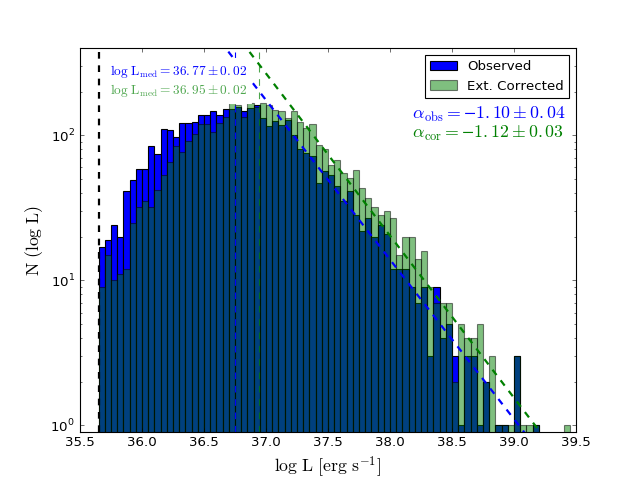

36.7659540132
36.9471443971
42.9098972731
-1.09985024822
43.7747983166
-1.11827836257


In [7]:
%matplotlib nbagg
bb=80
# L detection thresold 
y=plt.hist(lumi[(lumi > 35.65)], bins = bb, range=(35.5,39.5), log=True, label='Observed')
plt.xlabel('$\mathrm{log\,\,L\,\,[erg\,\,s^{-1}]}$', fontname='Helvetica',fontsize=16)
plt.ylabel('$\mathrm{N\,\,(log\,\,L)}$', fontname='Helvetica',fontsize=16)
plt.axvline(35.65, color='k', linestyle='--', linewidth = 2)
print np.median(lumi[(lumi > 35.65)])
print np.median(lumi2[(lumi2 > 35.65)])


yy = y[0]
xx = y[1]
yy = np.log10(yy)
yy[(np.isfinite(yy) == False)]=0
#print yy[l:bb-k]
#print xx[l:bb-k]

l=31
k=5
m,b = polyfit(xx[l:bb-k], (yy[l:bb-k]), 1) 
print b
print m
plt.plot(xx[l-20:bb]+0.025,10**(m*xx[l-20:bb]+b), '--b', linewidth = 2 ) 

plt.ylim(0.9,250)
plt.xlim(35,39.5)
plt.annotate(r'$\alpha$'+'$\mathrm{_{obs} = \minus1.10\pm0.04}$',xy=(0.67,0.815),xycoords='axes fraction',\
            fontsize=16.0, color='b')

y=plt.hist(lumi2[(lumi2 > 35.65)], bins = bb, range=(35.5,39.5), log=True, alpha=0.5, label='Ext. Corrected')


yy = y[0]
xx = y[1]
yy = np.log10(yy)
yy[(np.isfinite(yy) == False)]=0
#print yy[l:bb-k]
#print xx[l:bb-k]

l=30
k=5
m,b = polyfit(xx[l:bb-k], (yy[l:bb-k]), 1) 
print b
print m
plt.plot(xx[l-20:bb]+0.025,10**(m*xx[l-20:bb]+b), '--g', linewidth = 2 ) 
plt.axvline(np.median(lumi[(lumi2 > 35.65)]), color='b', linestyle='--')
plt.axvline(np.median(lumi2[(lumi2 > 35.65)]), color='g', linestyle='--', alpha=0.7)

plt.ylim(0.9,400)
plt.xlim(35.5,39.5)
plt.annotate(r'$\alpha$'+'$\mathrm{_{cor} = \minus1.12\pm0.03}$',xy=(0.67,0.765),xycoords='axes fraction',\
            fontsize=16.0, color='g')
plt.legend(loc='upper right',fontsize=12)

plt.annotate('$\mathrm{log\,\,L_{med} = 36.77\pm0.02}$',xy=(0.06,0.93),xycoords='axes fraction',\
            fontsize=12.0, color='b', backgroundcolor='w')
plt.annotate('$\mathrm{log\,\,L_{med} = 36.95\pm0.02}$',xy=(0.06,0.88),xycoords='axes fraction',\
            fontsize=12.0, color='g', alpha=0.7, backgroundcolor='w')

In [65]:
# Save the Plot in a .eps or .png file
plt.savefig('Lum_all.pdf', transparent=True, bbox_inches='tight', pad_inches=0.04)
#plt.savefig('test.png', dpi=1000)

<IPython.core.display.Javascript object>


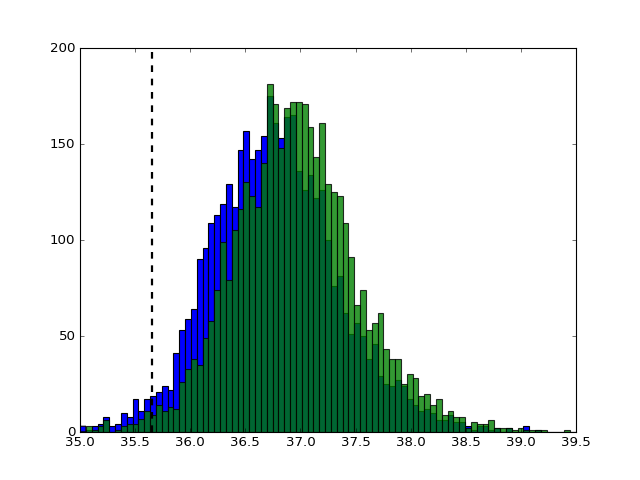

In [8]:
# Safety check of the luminosity function without the log...
%matplotlib nbagg
plt.hist(lumi, bins = 85, range=(35,39.5))
plt.hist(lumi2, bins = 85, range=(35,39.5), alpha=0.8)
plt.axvline(35.65, color='k', linestyle='--', linewidth = 2)


In [9]:
# Luminosity function of two subsamples using a thresold on the galactocentric radius (ra) map.

flux_tot2 = np.zeros(len(regx))
flux_tot3 = np.zeros(len(regx))
flux_tot4 = np.zeros(len(regx))
flux_tot5 = np.zeros(len(regx))

print len(np.where(lumi2 > 35.65)[0])
for i in range(0,len(regx)) :
    flux_tot2[i] = lumi2[i]
    flux_tot3[i] = lumi2[i]
    flux_tot4[i] = lumi2[i]
    flux_tot5[i] = lumi2[i]
    if ra[regy[i]-1,regx[i]-1] < 6500:
        flux_tot2[i] = 0
    if ra[regy[i]-1,regx[i]-1] >= 6500:
        flux_tot3[i] = 0
    if ra[regy[i]-1,regx[i]-1] < 8000:
        flux_tot4[i] = 0
    if ra[regy[i]-1,regx[i]-1] > 11000:
        flux_tot5[i] = 0

print np.median(flux_tot2[np.where(flux_tot2 > 0)[0]]) # sample 1 median
print np.median(flux_tot3[np.where(flux_tot3 > 0)[0]]) # sample 2 median
print len(np.where(flux_tot2 > 35.65)[0]) # sample 1 size
print len(np.where(flux_tot3 > 35.65)[0]) # sample 2 size

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:16: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


4158
36.8652043111
37.0127860894
2087
2071


/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:18: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


<IPython.core.display.Javascript object>


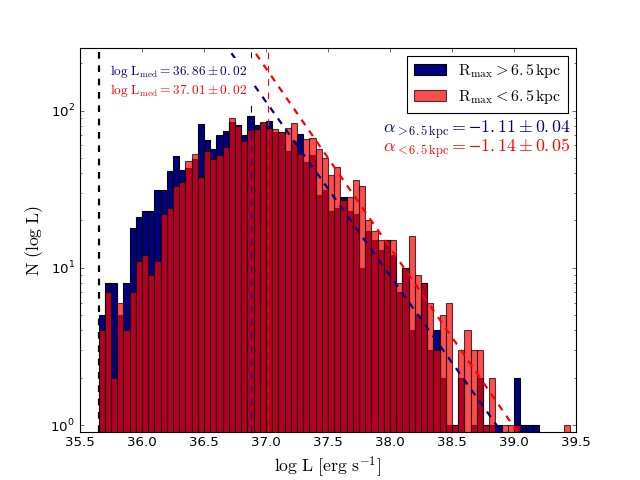

42.9786637995
-1.10676667004
44.4605605181
-1.14109523564
36.8652043111
37.0127860894


In [10]:
%matplotlib nbagg
y=plt.hist(flux_tot2[(lumi2 > 35.65)], bins = 80, range=(35.5,39.5),log=True, \
         color=(0,0,0.5),label='$\mathrm{R_{max}>6.5\,kpc}$')
yy = y[0]
xx = y[1]
yy = np.log10(yy)
yy[(np.isfinite(yy) == False)]=0
#print yy[l:bb-k]
#print xx[l:bb-k]

l=35
k=9
m,b = polyfit(xx[l:bb-k], (yy[l:bb-k]), 1) 
print b
print m
plt.plot(xx[l-20:bb]+0.025,10**(m*xx[l-20:bb]+b), '--',color=(0,0,0.5), linewidth = 2 ) 

y=plt.hist(flux_tot3[(lumi2 > 35.65)], bins = 80, range=(35.5,39.5),log=True,alpha=0.7, \
         color='r', label='$\mathrm{R_{max}<6.5\,kpc}$')
yy = y[0]
xx = y[1]
yy = np.log10(yy)
yy[(np.isfinite(yy) == False)]=0
#print yy[l:bb-k]
#print xx[l:bb-k]

l=38
k=9
m,b = polyfit(xx[l:bb-k], (yy[l:bb-k]), 1) 
print b
print m
plt.plot(xx[l-20:bb]+0.025,10**(m*xx[l-20:bb]+b), '--r', linewidth = 2 ) 

plt.ylim(0.9,250)
plt.xlim(35.5,39.5)
plt.xlabel('$\mathrm{log\,\,L\,\,[erg\,\,s^{-1}]}$', fontname='Helvetica',fontsize=16)
plt.ylabel('$\mathrm{N\,\,(log\,\,L)}$', fontname='Helvetica',fontsize=16)
plt.legend(loc='upper right')
plt.axvline(np.median(flux_tot2[np.where(flux_tot2 > 35.65)[0]]), color=(0,0,0.5), linestyle='--')
plt.axvline(np.median(flux_tot3[np.where(flux_tot3 > 35.65)[0]]), color='r', linestyle='--')
plt.axvline(35.65, color='k', linestyle='--', linewidth = 2)
#plt.axvline(np.median(flux_tot4[np.where(flux_tot4 > 0)[0]]), color='g', linestyle='--')
#plt.axvline(np.median(flux_tot5[np.where(flux_tot5 > 0)[0]]), color='purple', linestyle='--')
print np.median(flux_tot2[np.where(flux_tot2 > 0)[0]])
print np.median(flux_tot3[np.where(flux_tot3 > 0)[0]])

plt.annotate('$\mathrm{log\,\,L_{med} = 36.86\pm0.02}$',xy=(0.06,0.93),xycoords='axes fraction',\
            fontsize=12.0, color=(0,0,0.5), backgroundcolor='w')
plt.annotate('$\mathrm{log\,\,L_{med} = 37.01\pm0.02}$',xy=(0.06,0.88),xycoords='axes fraction',\
            fontsize=12.0, color='r', backgroundcolor='w')
plt.annotate(r'$\alpha$'+'$\mathrm{_{>6.5\,kpc} = \minus1.11\pm0.04}$',xy=(0.61,0.78),xycoords='axes fraction',\
            fontsize=16.0, color=(0,0,0.5))
plt.annotate(r'$\alpha$'+'$\mathrm{_{<6.5\,kpc} = \minus1.14\pm0.05}$',xy=(0.61,0.73),xycoords='axes fraction',\
            fontsize=16.0, color='r')

In [94]:
#Save the Plot in a .eps or .png file
plt.savefig('Lum_in_out.pdf', transparent=True, bbox_inches='tight', pad_inches=0.04)
#plt.savefig('test.png', dpi=1000)

4158
4083
4285
4285
2075
2083


<IPython.core.display.Javascript object>


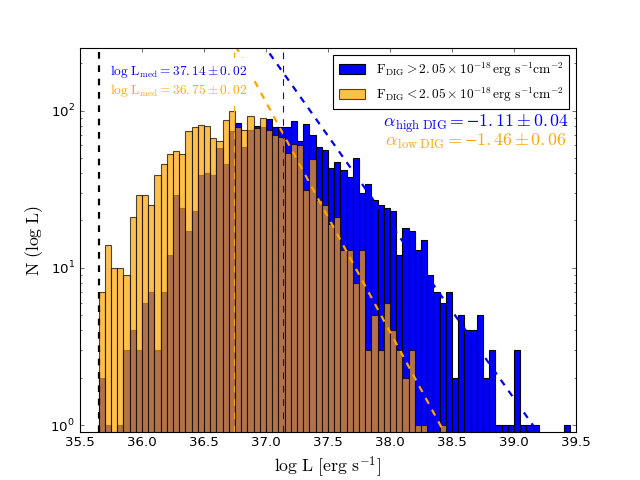

43.5854832427
-1.11400157322
56.1063405168
-1.46188908067
37.1361994735
36.7538028869


In [11]:
%matplotlib nbagg
# Luminosity function of two subsamples using a thresold on the galactocentric radius (ra) map.

flux_tot6 = np.zeros(len(regx))
flux_tot7 = np.zeros(len(regx))
print len(np.where(lumi2 > 35.65)[0])
print len(np.where(lumi > 35.65)[0])
print len(regx)
print len(med)
for i in range(0,len(regx)) :
    flux_tot6[i] = lumi2[i]
    flux_tot7[i] = lumi2[i]
    if med[i] < 2.05e-18:
        flux_tot6[i] = 0
    if med[i] >= 2.05e-18:
        flux_tot7[i] = 0

#print np.median(flux_tot6[np.where(flux_tot6 > 0)[0]]) # sample 1 median
#print np.median(flux_tot7[np.where(flux_tot7 > 0)[0]]) # sample 2 median
print len(np.where(flux_tot6 > 35.65)[0]) # sample 1 size
print len(np.where(flux_tot7 > 35.65)[0]) # sample 2 size
y=plt.hist(flux_tot6[(lumi2 > 35.65)], bins = 80, range=(35.5,39.5),log=True, color='b', label=r'$\mathrm{F_{DIG}>2.05\times10^{-18}\,erg\,\,s^{-1}cm^{-2}}$')


yy = y[0]
xx = y[1]
yy = np.log10(yy)
yy[(np.isfinite(yy) == False)]=0
#print yy[l:bb-k]
#print xx[l:bb-k]

l=40
k=5
m,b = polyfit(xx[l:bb-k], (yy[l:bb-k]), 1)

print b
print m
plt.plot(xx[l-20:bb]+0.025,10**(m*xx[l-20:bb]+b), '--b', linewidth = 2 ) 

y=plt.hist(flux_tot7[(lumi2 > 35.65)], bins = 80, range=(35.5,39.5),log=True,alpha=0.7, \
         color='orange', label=r'$\mathrm{F_{DIG}<2.05\times10^{-18}\,erg\,\,s^{-1}cm^{-2}}$')

yy = y[0]
xx = y[1]
yy = np.log10(yy)
yy[(np.isfinite(yy) == False)]=0
#print yy[l:bb-k]
#print xx[l:bb-k]

l=33
k=18
m,b = polyfit(xx[l:bb-k], (yy[l:bb-k]), 1) 
print b
print m
plt.plot(xx[l-20:bb]+0.025,10**(m*xx[l-20:bb]+b), '--',c='orange', linewidth = 2 ) 
plt.ylim(0.9,250)
plt.xlim(35.5,39.5)
plt.xlabel('$\mathrm{log\,\,L\,\,[erg\,\,s^{-1}]}$', fontname='Helvetica',fontsize=16)
plt.ylabel('$\mathrm{N\,\,(log\,\,L)}$', fontname='Helvetica',fontsize=16)
plt.legend(loc='upper right',fontsize=12)
plt.axvline(np.median(flux_tot6[np.where(flux_tot6 > 0)[0]]), color='b', linestyle='--')
plt.axvline(np.median(flux_tot7[np.where(flux_tot7 > 0)[0]]), color='orange', linestyle='--')
plt.axvline(35.65, color='k', linestyle='--', linewidth = 2)
#plt.axvline(np.median(flux_tot4[np.where(flux_tot4 > 0)[0]]), color='g', linestyle='--')
#plt.axvline(np.median(flux_tot5[np.where(flux_tot5 > 0)[0]]), color='purple', linestyle='--')
print np.median(flux_tot6[np.where(flux_tot6 > 35.65)[0]])
print np.median(flux_tot7[np.where(flux_tot7 > 35.65)[0]])

plt.annotate('$\mathrm{log\,\,L_{med} = 37.14\pm0.02}$',xy=(0.06,0.93),xycoords='axes fraction',\
            fontsize=12.0, color='b', backgroundcolor='w')
plt.annotate('$\mathrm{log\,\,L_{med} = 36.75\pm0.02}$',xy=(0.06,0.88),xycoords='axes fraction',\
            fontsize=12.0, color='orange', backgroundcolor='w')
plt.annotate(r'$\alpha$'+'$\mathrm{_{high\,\,DIG} = \minus1.11\pm0.04}$',xy=(0.61,0.795),xycoords='axes fraction',\
            fontsize=16.0, color='b')
plt.annotate(r'$\,\alpha$'+'$\mathrm{_{low\,\,DIG} = \minus1.46\pm0.06}$',xy=(0.61,0.745),xycoords='axes fraction',\
            fontsize=16.0, color='orange')

In [98]:
#Save the Plot in a .eps or .png file
plt.savefig('Lum_DIG.pdf', transparent=True, bbox_inches='tight', pad_inches=0.04)
#plt.savefig('test.png', dpi=1000)

# Halpha flux profile of typical regions

In [12]:
i=3596
print med[i]
xxyy=np.where(grow == i+1)
flux_prof=flux[xxyy[0],xxyy[1]]
#print flux_prof
dist=d[xxyy[0],xxyy[1]]
max = np.mean(flux_prof[(dist == np.min(dist))])
#print max
#print dist
#print flux_prof/(np.max(flux_prof)-np.median(flux_prof[(dist > np.max(dist)-50)]))

5.06115090002e-17


In [15]:
mod.fit?

Object `mod.fit` not found.


9.19606e-19
100.0
[[Model]]
    Model(pvoigt)
[[Fit Statistics]]
    # function evals   = 183
    # data points      = 73
    # variables        = 3
    chi-square         = 1.3680219e-36
    reduced chi-square = 0.000
    Akaike info crit   = -6335.521
    Bayesian info crit = -6328.650
[[Variables]]
    amplitude:   2.0732e-16 (init= 1.103527e-16)
    sigma:       89.9999986 (init= 30)
    center:      0 (fixed)
    fraction:    0.89999967 (init= 0)
    fwhm:        179.999997  == '2.0000000*sigma'
[[Correlations]] (unreported correlations are <  0.250)

(array([  7.68134534e-19]), 3.5737006604567347e-19, 89.999998608350012, 0.89999967051966834)


<IPython.core.display.Javascript object>


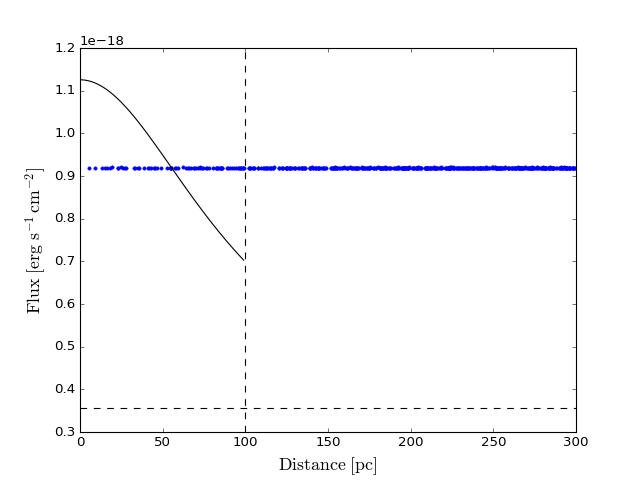

In [13]:
%matplotlib nbagg

name = 'Transient'
i=10

dist = np.array(len(np.where(grow == i+1)[0]))
flux_prof = np.array(len(np.where(grow == i+1)[0]))

xxyy = np.where(grow == i+1)
dist = d[xxyy[0],xxyy[1]]
flux_prof = flux[xxyy[0],xxyy[1]]
maxi = np.mean(flux_prof[(dist < 35)])
print maxi

x2 = dist[(dist < 300)]
y2 = flux_prof[(dist < 300)]-med[i]

xx = np.where((flux_prof/maxi > 0.6) & (dist > 100)) 
flux_prof[xx] = 0

x = dist[(flux_prof > 0) & (dist < 300)]
y = flux_prof[(flux_prof > 0) & (dist < 300)]-med[i]
print lim[i]
#print x
#print y

mod = PseudoVoigtModel()
mod.set_param_hint('amplitude', value = maxi*120, vary = maxi/100, )
mod.set_param_hint('sigma', value=30, max=90)
mod.set_param_hint('center', value=0, vary=0)
mod.set_param_hint('fraction', value=0, min=0, max=0.9)
mod.set_param_hint('fwhm', value=80)
pars = mod.make_params()
out = mod.fit(y, pars, x=x, method='nelder')
params = out.params
#print mod.fit(y, pars, x=x)
#plt.plot(x,y,'.')
#plt.plot(np.arange(200),PseudoVoigtModel(1.35e-15,41,0,0.75,82.5), '.')
#plt.show
def pdv(x, a, cent,sig,frac):
    return (1-frac)*a*np.exp(-(x-cent)**2/(2*(sig/(2*np.log(2))**0.5)**2))/((sig/(2*np.log(2))**0.5)*(2*np.pi)**0.5)+frac*a*sig/(np.pi*((x-cent)**2+sig**2))
a = params['amplitude']
cent = params['center']
sig = params['sigma']
frac = params['fraction']
sigg = params['fwhm']
print(out.fit_report(min_correl=0.25))

print ( (1-frac)*a*np.exp(-(np.arange(1)-cent)**2/(2*(sig/(2*np.log(2))**0.5)**2))/((sig/(2*np.log(2))**0.5)*(2*np.pi)**0.5)+\
            frac*a*sig/(np.pi*((np.arange(1)-cent)**2+sig**2)),med[i],sig*1,frac*1)
plt.plot(x2, y2+med[i], '.')
#plt.plot(x, out.init_fit+med[i], 'k--')
plt.plot(np.arange(lim[i]), (1-frac)*a*np.exp(-(np.arange(lim[i])-cent)**2/(2*(sig/(2*np.log(2))**0.5)**2))/((sig/(2*np.log(2))**0.5)*(2*np.pi)**0.5)+\
            frac*a*sig/(np.pi*((np.arange(lim[i])-cent)**2+sig**2))+med[i], 'k-')
#plt.annotate(name,xy=(0.8,0.9),xycoords='axes fraction',\
#            fontsize=16.0, horizontalalignment='center',verticalalignment='bottom', \
#             color='k', fontname='times', fontweight='bold')
plt.axhline(med[i], color='k', linestyle='--')
plt.axvline(lim[i], color='k', linestyle='--')
plt.ylabel('$\mathrm{Flux\,\,[erg\,\,s^{-1}\,cm^{-2}]}$', fontname='Helvetica',fontsize=16)
plt.xlabel('$\mathrm{Distance\,\,[pc]}$', fontname='Helvetica',fontsize=16)
plt.show()

In [16]:
#Save the Plot in a .eps or .png file
plt.savefig('Lum_prof_fila.eps', transparent=True, bbox_inches='tight', pad_inches=0.04)
#plt.savefig('test.png', dpi=1000)

369
1.62665e-17
1.62665e-17
[[Model]]
    Model(pvoigt)
[[Fit Statistics]]
    # function evals   = 89
    # data points      = 300
    # variables        = 3
    chi-square         = 0.000
    reduced chi-square = 0.000
    Akaike info crit   = -24506.892
    Bayesian info crit = -24495.781
[[Variables]]
    amplitude:   1.6827e-15 +/- 6.34e-17 (3.77%) (init= 1.951976e-15)
    sigma:       45.8844046 +/- 3.639528 (7.93%) (init= 30)
    center:      0 (fixed)
    fraction:    0.89626933 +/- 29.91439 (3337.66%) (init= 0)
    fwhm:        91.7688092 +/- 7.279056 (7.93%)  == '2.0000000*sigma'
[[Correlations]] (unreported correlations are <  0.250)
    C(sigma, fraction)           =  0.783 
    C(amplitude, fraction)       = -0.661 
    C(amplitude, sigma)          = -0.440 

(array([  1.22492807e-17]), 3.9930535204705995e-18, 45.8844046441634, 0.8962693311728582)


<IPython.core.display.Javascript object>


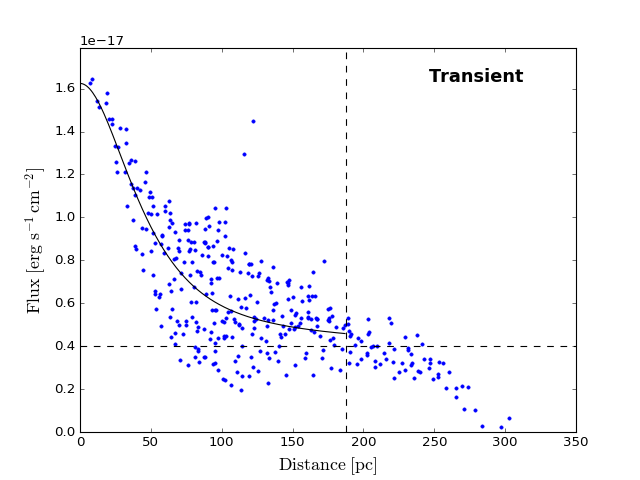

In [14]:
%matplotlib nbagg

name = 'Transient'
i=2687

dist = np.array(len(np.where(grow == i+1)[0]))
flux_prof = np.array(len(np.where(grow == i+1)[0]))
print len(np.where(grow == i+1)[0])# number of pixels

xxyy = np.where(grow == i+1)
dist = d[xxyy[0],xxyy[1]]
flux_prof = flux[xxyy[0],xxyy[1]]
maxi = np.mean(flux_prof[(dist < np.min(dist)+1)])
print maxi

medd=med[i]

x2 = dist[(dist < 350)]
y2 = flux_prof[(dist < 350)]-medd

xx = np.where((flux_prof/maxi > 0.6) & (dist > 100)) 
flux_prof[xx] = -10

x = dist[(flux_prof > -9) & (dist < lim[i])]
y = flux_prof[(flux_prof > -9) & (dist < lim[i])]-medd
print maxi
#print x
#print y

mod = PseudoVoigtModel()
mod.set_param_hint('amplitude', value = maxi*120, vary = maxi/100, )
mod.set_param_hint('sigma', value=30, max=90)
mod.set_param_hint('center', value=0, vary=0)
mod.set_param_hint('fraction', value=0, min=0, max=0.9)
mod.set_param_hint('fwhm', value=80)
pars = mod.make_params()
out = mod.fit(y, pars, x=x)
params = out.params
#print mod.fit(y, pars, x=x)
#plt.plot(x,y,'.')
#plt.plot(np.arange(200),PseudoVoigtModel(1.35e-15,41,0,0.75,82.5), '.')
#plt.show
def pdv(x, a, cent,sig,frac):
    return (1-frac)*a*np.exp(-(x-cent)**2/(2*(sig/(2*np.log(2))**0.5)**2))/((sig/(2*np.log(2))**0.5)*(2*np.pi)**0.5)+frac*a*sig/(np.pi*((x-cent)**2+sig**2))
a = params['amplitude']
cent = params['center']
sig = params['sigma']
frac = params['fraction']
sigg = params['fwhm']

print(out.fit_report(min_correl=0.25))

print ( (1-frac)*a*np.exp(-(np.arange(1)-cent)**2/(2*(sig/(2*np.log(2))**0.5)**2))/((sig/(2*np.log(2))**0.5)*(2*np.pi)**0.5)+\
            frac*a*sig/(np.pi*((np.arange(1)-cent)**2+sig**2)),medd,sig*1,frac*1)
plt.plot(x2, (y2+medd), '.')
#plt.plot(x, out.init_fit+med[i], 'k--')
plt.plot(np.arange(lim[i]), ((1-frac)*a*np.exp(-(np.arange(lim[i])-cent)**2/(2*(sig/(2*np.log(2))**0.5)**2))/((sig/(2*np.log(2))**0.5)*(2*np.pi)**0.5)+\
            frac*a*sig/(np.pi*((np.arange(lim[i])-cent)**2+sig**2))+medd), 'k-')

plt.ylabel('$\mathrm{Flux\,\,[erg\,\,s^{-1}\,cm^{-2}]}$', fontname='Helvetica',fontsize=16)
plt.xlabel('$\mathrm{Distance\,\,[pc]}$', fontname='Helvetica',fontsize=16)
#plt.annotate('DIG Background',xy=(0.85,0.18),xycoords='axes fraction',\
#            fontsize=12.0, horizontalalignment='center',verticalalignment='bottom', \
#             color='k', fontname='times', fontweight='bold')
#plt.annotate('Outer Limit',xy=(0.52,0.735),xycoords='axes fraction',\
#            fontsize=12.0, horizontalalignment='center',verticalalignment='bottom', \
#             color='k', fontname='times', fontweight='bold', rotation=90)
plt.annotate(name,xy=(0.8,0.9),xycoords='axes fraction',\
            fontsize=16.0, horizontalalignment='center',verticalalignment='bottom', \
             color='k', fontname='times', fontweight='bold')
plt.axhline(med[i], color='k', linestyle='--')
plt.axvline(lim[i], color='k', linestyle='--')
plt.ylim(-0.,1.1*maxi)
plt.xlim(0,350)
plt.show()

In [483]:
#Save the Plot in a .eps or .png file
plt.savefig('Lum_prof_lim_DIG.eps', transparent=True, bbox_inches='tight', pad_inches=0.04)
#plt.savefig('test.png', dpi=1000)

In [18]:
#Save the Plot in a .eps or .png file
plt.savefig('Lum_prof_fila.eps', transparent=True, bbox_inches='tight', pad_inches=0.04)
#plt.savefig('test.png', dpi=1000)

381
9.05885e-18
9.05885e-18
[[Model]]
    Model(pvoigt)
[[Fit Statistics]]
    # function evals   = 173
    # data points      = 280
    # variables        = 3
    chi-square         = 7.3962881e-34
    reduced chi-square = 0.000
    Akaike info crit   = -22932.077
    Bayesian info crit = -22921.173
[[Variables]]
    amplitude:   1.3137e-15 (init= 1.449416e-15)
    sigma:       59.9999989 (init= 20)
    center:      0 (fixed)
    fraction:    0.89999999 (init= 0.5)
    fwhm:        119.999997  == '2.0000000*sigma'
[[Correlations]] (unreported correlations are <  0.250)

(array([  7.30098316e-18]), 1.7807595925829864e-18, 59.999998901071308, 0.89999999959220367)


<IPython.core.display.Javascript object>


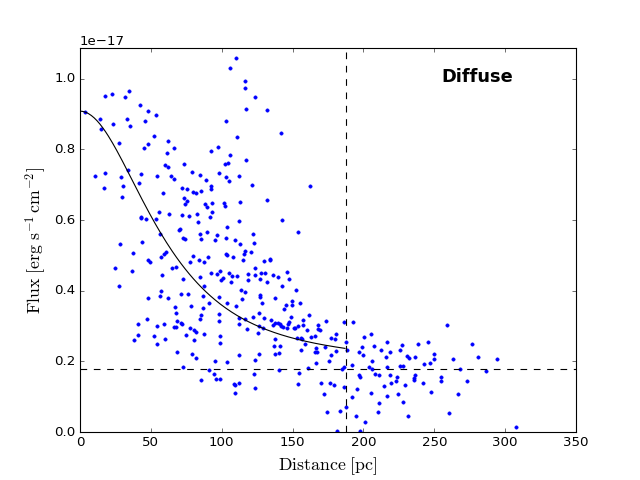

In [15]:
%matplotlib nbagg

name = 'Diffuse'
i=833

dist = np.array(len(np.where(grow == i+1)[0]))
flux_prof = np.array(len(np.where(grow == i+1)[0]))
print len(np.where(grow == i+1)[0])# number of pixels

xxyy = np.where(grow == i+1)
dist = d[xxyy[0],xxyy[1]]
flux_prof = flux[xxyy[0],xxyy[1]]
maxi = np.mean(flux_prof[(dist < np.min(dist)+1)])
print maxi

medd=med[i]

x2 = dist[(dist < 350)]
y2 = flux_prof[(dist < 350)]-medd

xx = np.where((flux_prof/maxi > 0.6) & (dist > 100)) 
flux_prof[xx] = -10

x = dist[(flux_prof > -9) & (dist < lim[i])]
y = flux_prof[(flux_prof > -9) & (dist < lim[i])]-medd
print maxi
#print x
#print y

mod = PseudoVoigtModel()
mod.set_param_hint('amplitude', value = maxi*160 )
mod.set_param_hint('sigma', value=20, max=60)
mod.set_param_hint('center', value=0, vary=0)
mod.set_param_hint('fraction', value=0.5,min=0, max=0.9)
mod.set_param_hint('fwhm', value=40)
pars = mod.make_params()
out = mod.fit(y, pars, x=x, method='nelder')
params = out.params
#print mod.fit(y, pars, x=x)
#plt.plot(x,y,'.')
#plt.plot(np.arange(200),PseudoVoigtModel(1.35e-15,41,0,0.75,82.5), '.')
#plt.show
def pdv(x, a, cent,sig,frac):
    return (1-frac)*a*np.exp(-(x-cent)**2/(2*(sig/(2*np.log(2))**0.5)**2))/((sig/(2*np.log(2))**0.5)*(2*np.pi)**0.5)+frac*a*sig/(np.pi*((x-cent)**2+sig**2))
a = params['amplitude']
cent = params['center']
sig = params['sigma']
frac = params['fraction']
sigg = params['fwhm']
print(out.fit_report(min_correl=0.25))

print ( (1-frac)*a*np.exp(-(np.arange(1)-cent)**2/(2*(sig/(2*np.log(2))**0.5)**2))/((sig/(2*np.log(2))**0.5)*(2*np.pi)**0.5)+\
            frac*a*sig/(np.pi*((np.arange(1)-cent)**2+sig**2)),medd,sig*1,frac*1)
plt.plot(x2, (y2+medd), '.')
#plt.plot(x, out.init_fit+med[i], 'k--')
plt.plot(np.arange(lim[i]), ((1-frac)*a*np.exp(-(np.arange(lim[i])-cent)**2/(2*(sig/(2*np.log(2))**0.5)**2))/((sig/(2*np.log(2))**0.5)*(2*np.pi)**0.5)+\
            frac*a*sig/(np.pi*((np.arange(lim[i])-cent)**2+sig**2))+medd), 'k-')

plt.ylabel('$\mathrm{Flux\,\,[erg\,\,s^{-1}\,cm^{-2}]}$', fontname='Helvetica',fontsize=16)
plt.xlabel('$\mathrm{Distance\,\,[pc]}$', fontname='Helvetica',fontsize=16)
#plt.annotate('DIG Background',xy=(0.85,0.14),xycoords='axes fraction',\
#            fontsize=12.0, horizontalalignment='center',verticalalignment='bottom', \
#             color='k', fontname='times', fontweight='bold')
#plt.annotate('Outer Limit',xy=(0.52,0.735),xycoords='axes fraction',\
#            fontsize=12.0, horizontalalignment='center',verticalalignment='bottom', \
#             color='k', fontname='times', fontweight='bold', rotation=90)
plt.annotate(name,xy=(0.8,0.9),xycoords='axes fraction',\
            fontsize=16.0, horizontalalignment='center',verticalalignment='bottom', \
             color='k', fontname='times', fontweight='bold')
plt.axhline(med[i], color='k', linestyle='--')
plt.axvline(lim[i], color='k', linestyle='--')
plt.ylim(-0.,1.2*maxi)
plt.xlim(0,350)
plt.show()

In [20]:
#Save the Plot in a .eps or .png file
plt.savefig('Lum_prof_diff.eps', transparent=True, bbox_inches='tight', pad_inches=0.04)
#plt.savefig('test.png', dpi=1000)

352
7.98084e-16
7.98084e-16
[[Model]]
    Model(pvoigt)
[[Fit Statistics]]
    # function evals   = 154
    # data points      = 352
    # variables        = 3
    chi-square         = 1.3268112e-31
    reduced chi-square = 0.000
    Akaike info crit   = -27084.269
    Bayesian info crit = -27072.678
[[Variables]]
    amplitude:   6.9725e-14 (init= 9.577012e-14)
    sigma:       35.8803171 (init= 30)
    center:      0 (fixed)
    fraction:    0.32188252 (init= 0.5)
    fwhm:        71.7606342  == '2.0000000*sigma'
[[Correlations]] (unreported correlations are <  0.250)

(array([  8.18078705e-16]), 1.2802369466253653e-17, 35.880317118157272, 0.32188252983516724)


<IPython.core.display.Javascript object>


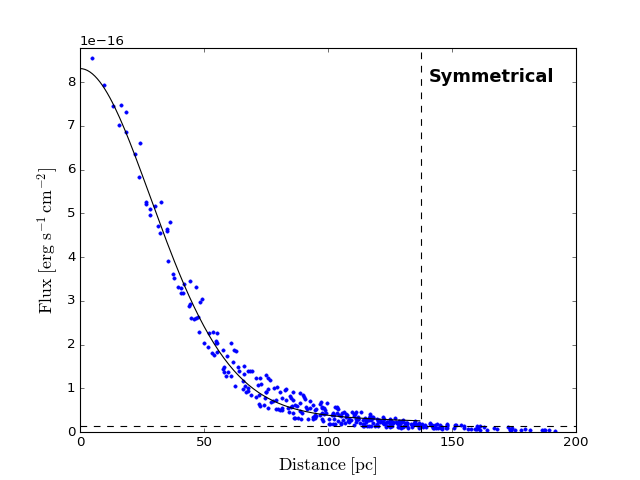

In [16]:
%matplotlib nbagg

name = 'Symmetrical'
i=2436

dist = np.array(len(np.where(grow == i+1)[0]))
flux_prof = np.array(len(np.where(grow == i+1)[0]))
print len(np.where(grow == i+1)[0])# number of pixels
xxyy = np.where(grow == i+1)
dist = d[xxyy[0],xxyy[1]]
flux_prof = flux[xxyy[0],xxyy[1]]
maxi = np.mean(flux_prof[(dist < 15)])
print maxi

x2 = dist[(dist < 300)]
y2 = flux_prof[(dist < 300)]-med[i]

xx = np.where((flux_prof/maxi > 0.6) & (dist > 100)) 
flux_prof[xx] = 0

x = dist[(flux_prof > 0) & (dist < 300)]
y = flux_prof[(flux_prof > 0) & (dist < 300)]-med[i]
print maxi
#print x
#print y

mod = PseudoVoigtModel()
mod.set_param_hint('amplitude', value = maxi*120, vary = maxi/100, )
mod.set_param_hint('sigma', value=30, max=90)
mod.set_param_hint('center', value=0, vary=0)
mod.set_param_hint('fraction', value=0.5, min=0, max=0.9)
mod.set_param_hint('fwhm', value=80)
pars = mod.make_params()
out = mod.fit(y, pars, x=x, method='nelder')
params = out.params
#print mod.fit(y, pars, x=x)
#plt.plot(x,y,'.')
#plt.plot(np.arange(200),PseudoVoigtModel(1.35e-15,41,0,0.75,82.5), '.')
#plt.show
def pdv(x, a, cent,sig,frac):
    return (1-frac)*a*np.exp(-(x-cent)**2/(2*(sig/(2*np.log(2))**0.5)**2))/((sig/(2*np.log(2))**0.5)*(2*np.pi)**0.5)+frac*a*sig/(np.pi*((x-cent)**2+sig**2))
a = params['amplitude']
cent = params['center']
sig = params['sigma']
frac = params['fraction']
sigg = params['fwhm']
print(out.fit_report(min_correl=0.25))

print ( (1-frac)*a*np.exp(-(np.arange(1)-cent)**2/(2*(sig/(2*np.log(2))**0.5)**2))/((sig/(2*np.log(2))**0.5)*(2*np.pi)**0.5)+\
            frac*a*sig/(np.pi*((np.arange(1)-cent)**2+sig**2)),med[i],sig*1,frac*1)
plt.plot(x2, (y2+med[i]), '.')
#plt.plot(x, out.init_fit+med[i], 'k--')
plt.plot(np.arange(lim[i]), ((1-frac)*a*np.exp(-(np.arange(lim[i])-cent)**2/(2*(sig/(2*np.log(2))**0.5)**2))/((sig/(2*np.log(2))**0.5)*(2*np.pi)**0.5)+\
            frac*a*sig/(np.pi*((np.arange(lim[i])-cent)**2+sig**2))+med[i]), 'k-')
plt.ylabel('$\mathrm{Flux\,\,[erg\,\,s^{-1}\,cm^{-2}]}$', fontname='Helvetica',fontsize=16)
plt.xlabel('$\mathrm{Distance\,\,[pc]}$', fontname='Helvetica',fontsize=16)
plt.annotate(name,xy=(0.83,0.9),xycoords='axes fraction',\
            fontsize=16.0, horizontalalignment='center',verticalalignment='bottom', \
             color='k', fontname='times', fontweight='bold')
plt.axhline(med[i], color='k', linestyle='--')
plt.axvline(lim[i], color='k', linestyle='--')
plt.ylim(-0.,maxi*1.1)
plt.xlim(0,200)
plt.show()

In [22]:
#Save the Plot in a .eps or .png file
plt.savefig('Lum_prof_sph.eps', transparent=True, bbox_inches='tight', pad_inches=0.04)
#plt.savefig('test.png', dpi=1000)

291
1.0107e-15
1.0107e-15
[[Model]]
    Model(pvoigt)
[[Fit Statistics]]
    # function evals   = 189
    # data points      = 291
    # variables        = 3
    chi-square         = 1.344714e-30
    reduced chi-square = 0.000
    Akaike info crit   = -21660.316
    Bayesian info crit = -21649.296
[[Variables]]
    amplitude:   1.2730e-13 (init= 1.212842e-13)
    sigma:       45.0087580 (init= 30)
    center:      0 (fixed)
    fraction:    0.68547987 (init= 0.5)
    fwhm:        90.0175161  == '2.0000000*sigma'
[[Correlations]] (unreported correlations are <  0.250)

(array([  1.03499866e-15]), 2.5943224547886455e-17, 45.008758071691432, 0.68547987022772638)


<IPython.core.display.Javascript object>


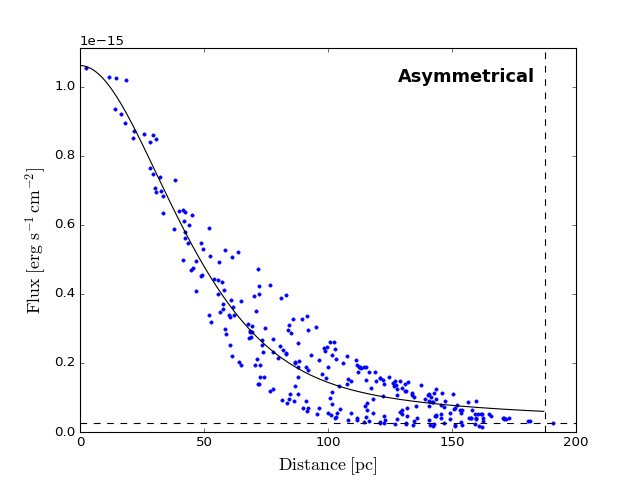

In [17]:
%matplotlib nbagg

name = 'Asymmetrical'
i=2986

dist = np.array(len(np.where(grow == i+1)[0]))
flux_prof = np.array(len(np.where(grow == i+1)[0]))
print len(np.where(grow == i+1)[0])# number of pixels
xxyy = np.where(grow == i+1)
dist = d[xxyy[0],xxyy[1]]
flux_prof = flux[xxyy[0],xxyy[1]]
maxi = np.mean(flux_prof[(dist < 15)])
print maxi

x2 = dist[(dist < 300)]
y2 = flux_prof[(dist < 300)]-med[i]

xx = np.where((flux_prof/maxi > 0.6) & (dist > 100)) 
flux_prof[xx] = 0

x = dist[(flux_prof > 0) & (dist < 300)]
y = flux_prof[(flux_prof > 0) & (dist < 300)]-med[i]
print maxi
#print x
#print y

mod = PseudoVoigtModel()
mod.set_param_hint('amplitude', value = maxi*120, vary = maxi/100, )
mod.set_param_hint('sigma', value=30, max=90)
mod.set_param_hint('center', value=0, vary=0)
mod.set_param_hint('fraction', value=0.5, min=0, max=0.9)
mod.set_param_hint('fwhm', value=80)
pars = mod.make_params()
out = mod.fit(y, pars, x=x, method='nelder')
params = out.params
#print mod.fit(y, pars, x=x)
#plt.plot(x,y,'.')
#plt.plot(np.arange(200),PseudoVoigtModel(1.35e-15,41,0,0.75,82.5), '.')
#plt.show
def pdv(x, a, cent,sig,frac):
    return (1-frac)*a*np.exp(-(x-cent)**2/(2*(sig/(2*np.log(2))**0.5)**2))/((sig/(2*np.log(2))**0.5)*(2*np.pi)**0.5)+frac*a*sig/(np.pi*((x-cent)**2+sig**2))
a = params['amplitude']
cent = params['center']
sig = params['sigma']
frac = params['fraction']
sigg = params['fwhm']
print(out.fit_report(min_correl=0.25))

print ( (1-frac)*a*np.exp(-(np.arange(1)-cent)**2/(2*(sig/(2*np.log(2))**0.5)**2))/((sig/(2*np.log(2))**0.5)*(2*np.pi)**0.5)+\
            frac*a*sig/(np.pi*((np.arange(1)-cent)**2+sig**2)),med[i],sig*1,frac*1)
plt.plot(x2, (y2+med[i]), '.')
#plt.plot(x, out.init_fit+med[i], 'k--')
plt.plot(np.arange(lim[i]), ((1-frac)*a*np.exp(-(np.arange(lim[i])-cent)**2/(2*(sig/(2*np.log(2))**0.5)**2))/((sig/(2*np.log(2))**0.5)*(2*np.pi)**0.5)+\
            frac*a*sig/(np.pi*((np.arange(lim[i])-cent)**2+sig**2))+med[i]), 'k-')
plt.ylabel('$\mathrm{Flux\,\,[erg\,\,s^{-1}\,cm^{-2}]}$', fontname='Helvetica',fontsize=16)
plt.xlabel('$\mathrm{Distance\,\,[pc]}$', fontname='Helvetica',fontsize=16)
plt.annotate(name,xy=(0.78,0.9),xycoords='axes fraction',\
            fontsize=16.0, horizontalalignment='center',verticalalignment='bottom', \
             color='k', fontname='times', fontweight='bold')
plt.axhline(med[i], color='k', linestyle='--')
plt.axvline(lim[i], color='k', linestyle='--')
plt.ylim(-0.,1.1*maxi)
plt.xlim(0,200)
plt.show()

In [24]:
#Save the Plot in a .eps or .png file
plt.savefig('Lum_prof_asym.eps', transparent=True, bbox_inches='tight', pad_inches=0.04)
#plt.savefig('test.png', dpi=1000)

In [21]:
# To find posible errors with low flux regions
print np.where((flux_tot < 5e-17))

(array([   5,    6,    7,   10,   13,   14,   16,   31,   35,   49,  104,
        109,  112,  131,  139,  148,  180,  217,  220,  245,  295,  336,
        441,  495,  531,  581,  590,  593,  669,  704,  788,  796,  800,
        806,  809,  837,  844,  859,  861,  910,  925,  938,  963,  982,
        983,  991, 1004, 1012, 1014, 1020, 1045, 1094, 1100, 1112, 1130,
       1152, 1154, 1345, 1349, 1418, 1437, 1474, 1491, 1566, 1570, 1593,
       1601, 1614, 1717, 1718, 1738, 1748, 1800, 1872, 1881, 1883, 1896,
       1899, 1960, 1970, 1994, 1996, 2007, 2049, 2068, 2070, 2109, 2132,
       2138, 2165, 2166, 2194, 2205, 2270, 2314, 2361, 2383, 2399, 2447,
       2451, 2468, 2478, 2493, 2526, 2538, 2568, 2627, 2628, 2653, 2694,
       2696, 2776, 2791, 2796, 2805, 2823, 2843, 2862, 2909, 2918, 2933,
       3004, 3010, 3025, 3028, 3056, 3063, 3079, 3087, 3088, 3174, 3255,
       3302, 3322, 3343, 3359, 3365, 3375, 3579, 3623, 3625, 3634, 3635,
       3704, 3714, 3719, 3729, 3734, 3771, 3778, 3

5.16926e-17
3.30388984725e-15
162.5
283.339
2.82022e-18


<IPython.core.display.Javascript object>


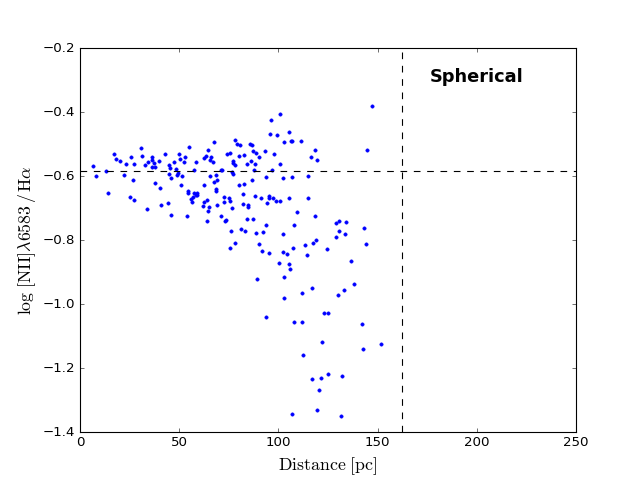

In [18]:
# To check the profile of some random regions "i"

on = fits.getdata('NGC628_ratio_OII_NII_carte.fits')
nh = fits.getdata('NGC628_ratio_NII_Ha_carte.fits')

%matplotlib nbagg
i=690

name = 'Spherical'

 
onr = np.array(len(np.where(grow == i+1)[0]))
nhr = np.array(len(np.where(grow == i+1)[0]))
dist = np.array(len(np.where(grow == i+1)[0]))
flux_prof = np.array(len(np.where(grow == i+1)[0]))

xxyy=np.where(grow == i+1)
dist=d[xxyy[0],xxyy[1]]
onr=on[xxyy[0],xxyy[1]]
nhr=nh[xxyy[0],xxyy[1]]
flux_prof=flux[xxyy[0],xxyy[1]]
max = np.mean(flux_prof[(dist == np.min(dist))])
print np.max(flux_prof)
print flux_tot[i]
print lim[i]
print np.max(d[(grow == i+1)])
print np.median(flux[(grow == i+1) & (d > lim[i]-25) & (d < lim[i]+25)])
#plt.plot(dist,flux_prof/max,'.b')
#plt.plot(dist[(onr < 4)],onr[(onr < 4)],'.b')
plt.plot(dist[(nhr < 2)],nhr[(nhr < 2)],'.b')
#plt.ylabel('$\mathrm{Flux_{normed}}$', fontname='Helvetica',fontsize=16)
#plt.ylabel('$\mathrm{log\,\,[OII]\lambda3727\,/\,[NII]\lambda6583\,}$', fontname='Helvetica',fontsize=16)
plt.ylabel('$\mathrm{log\,\,[NII]\lambda6583\,/\,H}$'+r'$\mathrm{\alpha}$', fontname='Helvetica',fontsize=16)


plt.xlabel('$\mathrm{Distance\,\,[pc]}$', fontname='Helvetica',fontsize=16)
plt.annotate(name,xy=(0.8,0.9),xycoords='axes fraction',\
            fontsize=16.0, horizontalalignment='center',verticalalignment='bottom', \
             color='k', fontname='times', fontweight='bold')
#plt.axhline(np.mean(onr[(dist < 10)]), color='k', linestyle='--')
plt.axhline(np.mean(nhr[(dist < 10) & (nhr < 10)]), color='k', linestyle='--')
#plt.axhline(med[i]/max, color='k', linestyle='--')
plt.xlim(0,250)
plt.ylim(-1.4,-0.2)
plt.axvline(lim[i], color='k', linestyle='--')
plt.show()


<IPython.core.display.Javascript object>


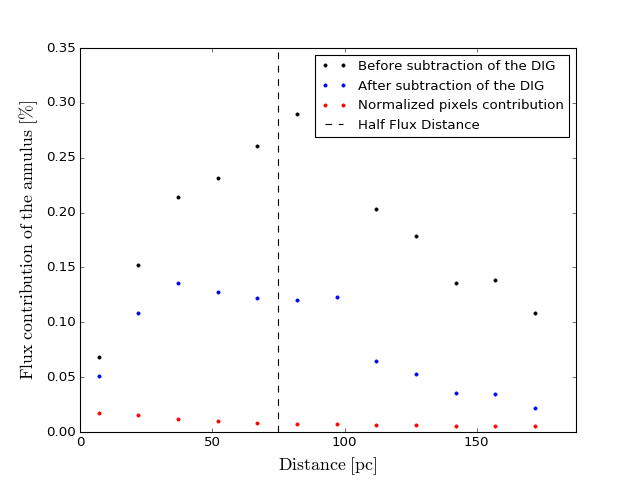

In [19]:
# To check the flux contribution of different distance annulus to the total flux 
# of some random regions "i"
%matplotlib nbagg

name = 'test'
i = 2687

h=15
n = int((lim[i]-lim[i]%h)/h)
#print n

dist = np.array(len(np.where(grow == i+1)[0]))
flux_prof = np.array(len(np.where(grow == i+1)[0]))

xxyy=np.where(grow == i+1)
dist=d[xxyy[0],xxyy[1]]
flux_prof=flux[xxyy[0],xxyy[1]]


fl = np.zeros(n)
fl2 = np.zeros(n)
fll = np.zeros(n)
fll2 = np.zeros(n)
flll2 = np.zeros(n)
dl = np.zeros(n)
#print np.max(flux_prof)
#print med[i]

for j in range(0,n) :
    fl[j]= np.sum(flux_prof[(dist < j*h+h) & (dist > j*h)]-med[i])
    fl2[j]= np.sum(flux_prof[(dist < j*h+h) & (dist > j*h)])
    fll2[j]= np.sum(flux_prof[(dist < j*h+h) & (dist > j*h)]-med[i])/len(flux_prof[(dist < j*h+h) & (dist > j*h)])
    flll2[j]= np.sum(flux_prof[(dist < j*h+h) & (dist > j*h)])/len(flux_prof[(dist < j*h+h) & (dist > j*h)])
    dl[j] = j*h
    fll[0] = fl[0]/flux_tot[i]
    fll[j] = np.sum(fl[0:j])/flux_tot[i]

#print fll
#print np.sum(fll[0:(lim[i]+12.5/25)])
#print dl[(fll > 0.5)][0]
#print lim[i]
plt.ylabel('$\mathrm{Flux\,\,contribution\,\,of\,\,the\,\,annulus\,\,[\%]}$', \
           fontname='Helvetica',fontsize=16)
plt.xlabel('$\mathrm{Distance\,\,[pc]}$', fontname='Helvetica',fontsize=16)
#max = np.mean(fl[(dl == np.min(dl))])
#plt.ylim(-0.5,1)
plt.xlim(0,lim[i])
plt.plot( dl+h/2, fl2/flux_tot[i], '.k', label='Before subtraction of the DIG')
plt.plot( dl+h/2, fl/flux_tot[i], '.b', label='After subtraction of the DIG')
plt.plot( dl+h/2, flll2/flux_tot[i], '.r',label='Normalized pixels contribution')
plt.axvline(dl[(fll > 0.5)][0], color='k', linestyle='--',label='Half Flux Distance' )
#plt.plot( dl+h/2, fll2/flux_tot[i], '.r')
plt.legend(loc='upper right',fontsize=12)
plt.show()


In [494]:
#Save the Plot in a .eps or .png file
plt.savefig('Flux_DIF_contribution.eps', transparent=True, bbox_inches='tight', pad_inches=0.04)
#plt.savefig('test.png', dpi=1000)

12


<IPython.core.display.Javascript object>


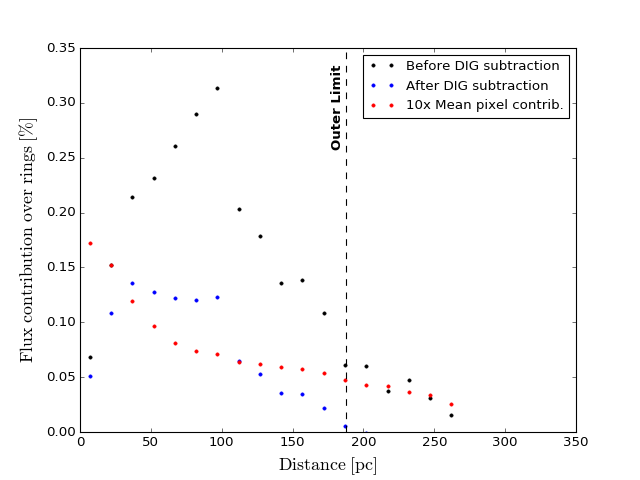

In [20]:
# To check the flux contribution of different distance annulus to the total flux 
# of some random regions "i"
%matplotlib nbagg

name = 'test'
i = 2687

h=15
n = int((lim[i]-lim[i]%h)/h)
print n
n=18
dist = np.array(len(np.where(grow == i+1)[0]))
flux_prof = np.array(len(np.where(grow == i+1)[0]))

xxyy=np.where(grow == i+1)
dist=d[xxyy[0],xxyy[1]]
flux_prof=flux[xxyy[0],xxyy[1]]


fl = np.zeros(n)
fl2 = np.zeros(n)
fll = np.zeros(n)
fll2 = np.zeros(n)
flll2 = np.zeros(n)
dl = np.zeros(n)
#print np.max(flux_prof)
#print med[i]

for j in range(0,n) :
    fl[j]= np.sum(flux_prof[(dist < j*h+h) & (dist > j*h)])-len(flux_prof[(dist < j*h+h) & (dist > j*h)])*med[i] 
    fl2[j]= np.sum(flux_prof[(dist < j*h+h) & (dist > j*h)])
    fll2[j]= np.sum(flux_prof[(dist < j*h+h) & (dist > j*h)]-med[i])/len(flux_prof[(dist < j*h+h) & (dist > j*h)])
    flll2[j]= np.sum(flux_prof[(dist < j*h+h) & (dist > j*h)])/len(flux_prof[(dist < j*h+h) & (dist > j*h)])
    dl[j] = j*h
    fll[0] = fl[0]/flux_tot[i]
    fll[j] = np.sum(fl[0:j])/flux_tot[i]

#print fll
#print np.sum(fll[0:(lim[i]+12.5/25)])
#print dl[(fll > 0.5)][0]
#print lim[i]
plt.ylabel('$\mathrm{Flux\,\,contribution\,\,over\,\,rings\,\,[\%]}$', \
           fontname='Helvetica',fontsize=16)
plt.xlabel('$\mathrm{Distance\,\,[pc]}$', fontname='Helvetica',fontsize=16)
#max = np.mean(fl[(dl == np.min(dl))])
plt.ylim(-0.0,0.35)
plt.xlim(0,350)
plt.plot( dl+h/2, fl2/flux_tot[i], '.k', label='Before DIG subtraction')
plt.plot( dl+h/2, fl/flux_tot[i], '.b', label='After DIG subtraction')
plt.plot( dl+h/2, flll2/flux_tot[i]*10, '.r',label='10x Mean pixel contrib.')
#plt.axvline(dl[(fll > 0.5)][0], color='k', linestyle='--',label='Half Flux Distance' )
plt.axvline(lim[i], color='k', linestyle='--' )
#plt.plot( dl+h/2, fll2/flux_tot[i], '.r')
plt.annotate('Outer Limit',xy=(0.52,0.735),xycoords='axes fraction',\
            fontsize=12.0, horizontalalignment='center',verticalalignment='bottom', \
             color='k', fontname='times', fontweight='bold', rotation=90)
plt.legend(loc='upper right',fontsize=12)
plt.show()


In [17]:
#Save the Plot in a .eps or .png file
plt.savefig('Flux_DIG_cont_lim.eps', transparent=True, bbox_inches='tight', pad_inches=0.04)
#plt.savefig('test.png', dpi=1000)

In [21]:
dlll=np.zeros(4285)
dlllc=np.zeros(4285)

for i in range(0,4285):
    h=3
    n = int((lim[i]-lim[i]%h)/h)
    #print n
    
    dist = np.array(len(np.where(grow == i+1)[0]))
    flux_prof = np.array(len(np.where(grow == i+1)[0]))
    
    xxyy=np.where(grow == i+1)
    dist=d[xxyy[0],xxyy[1]]
    flux_prof=flux2[xxyy[0],xxyy[1]]
    
    
    fl = np.zeros(n)
    fll = np.zeros(n)
    dl = np.zeros(n)
    
    for j in range(0,n) :
        fl[j]= np.sum(flux_prof[(dist < j*h+h) & (dist > j*h)]-med[i])
        dl[j] = j*h
        fll[0] = fl[0]/flux_tot[i]
        fll[j] = np.sum(fl[0:j])/flux_tot[i]
        #print fll
        dlllc[i] = np.sum(flux_prof[(dist < 14)])/flux_tot[i]
    if np.max(fll > 0.5):
        dlll[i] = dl[(fll > 0.5)][0]
    else :
        dlll[i] = 0
        #print dlll[i]    


In [22]:
#taille = np.zeros(4285)
#taille = (dlllc-0.1640)/(-0.0003056666)
#print taille

In [23]:
xc=np.zeros(16)
xc[0:16]=[1,25,50,100,150,200,350,500,1000,2000,5000,10000,20000,50000,100000,200000]
xc=np.log10(xc)
q=np.zeros(16)
r1=np.zeros(16)
r10=np.zeros(16)
r100=np.zeros(16)
r500=np.zeros(16)
r10075=np.zeros(16)
r10050=np.zeros(16)
r10020=np.zeros(16)
r1000=np.zeros(16)
r100db=np.zeros(16)
ffa = 0.0005
q=5.0754 + 42.0340*xc - 15.0797*xc**2 + 2.4439*xc**3 - 0.1474*xc**4
print q
for i in range(0,16):
    r1[i]=((3*10**q[i])/(4*3.14159*ffa*2.59*10**(-13)*1))**(1/3.0)/(3.085678e18)
    r10[i]=((3*10**q[i])/(4*3.14159*ffa*2.59*10**(-13)*100))**(1/3.0)/(3.085678e18)
    r100[i]=((3*10**q[i])/(4*3.14159*ffa*2.59*10**(-13)*10000))**(1/3.0)/(3.085678e18)
    r500[i]=((3*10**q[i])/(4*3.14159*ffa*2.59*10**(-13)*250000))**(1/3.0)/(3.085678e18)
    r10075[i]=((3*10**q[i])/(4*3.14159*ffa*3.28*10**(-13)*10000))**(1/3.0)/(3.085678e18)
    r10050[i]=((3*10**q[i])/(4*3.14159*ffa*4.54*10**(-13)*10000))**(1/3.0)/(3.085678e18)
    r10020[i]=((3*10**q[i])/(4*3.14159*ffa*1.43*10**(-13)*10000))**(1/3.0)/(3.085678e18)
    r1000[i]=((3*10**q[i])/(4*3.14159*ffa*2.59*10**(-13)*1000000))**(1/3.0)/(3.085678e18)
#    r100db[i]=((10**q[i])/(4*3.14159*xc[i]**(0.333)*(ffa)**(0.66)*(100)**(1.66)))**(0.5)/(3.085678e18*1000)
    r100db[i]=(3*10**(q[i]-11.86)/(2.87*xc[i]*1.5e32*(1)**0.9*100))**(1/3.0)
    
r100db[0]=0
print r100db

[  5.0754      40.48069006  43.71931614  46.0174      47.01537325
  47.59646563  48.47910907  48.90350852  49.506       49.9168218
  50.32486181  50.6114      50.91304307  51.33009972  51.6154      51.80200574]
[  0.00000000e+00   1.27678138e-02   1.43689877e-01   7.94034491e-01
   1.66066263e+00   2.54622719e+00   4.84815111e+00   6.58394488e+00
   1.00927368e+01   1.34000620e+01   1.76458683e+01   2.14204884e+01
   2.63555995e+01   3.52437180e+01   4.29727056e+01   4.86330150e+01]


In [24]:
flux_max = np.zeros(4285)
flux_max2 = np.zeros(4285)

for i in range(0,4285):
    
    xxyy=np.where((grow == i+1) & (d < 50))
    flux_max[i] = np.max(flux[xxyy[0],xxyy[1]])
    flux_max2[i] = np.max(flux2[xxyy[0],xxyy[1]])

<IPython.core.display.Javascript object>


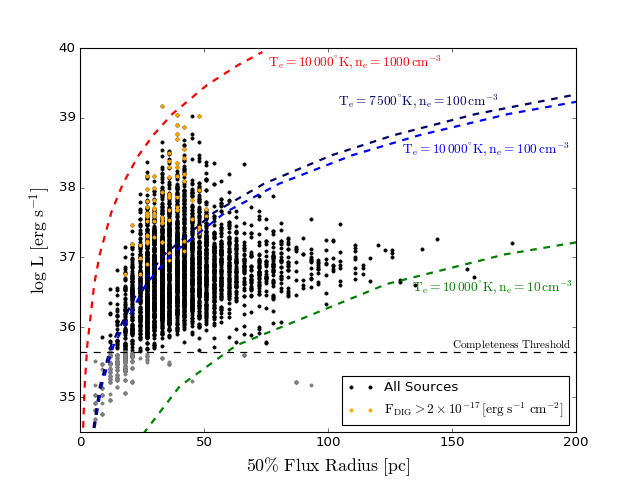

[35.781035157335566, 36.781035157335566, 37.781035157335566, 38.781035157335566, 39.781035157335566, 40.781035157335566]
[0.44209953728270357, 0.9524745795689005, 2.052044275596773, 4.420995372827034, 9.524745795689004, 20.52044275596773]
(array([  16,  601,  669,  808, 1999, 3025, 3258, 4284]),)


In [25]:
%matplotlib nbagg
j=0.4
plt.plot(dlll[(dlll > 0) & (med/flux_max < j)], lumi[(dlll > 0) & (med/flux_max < j)], '.', c='k',  label='All Sources')
plt.plot(dlll[(dlll > 0) & (med > 2e-17) & (med/flux_max < j)], lumi[(dlll > 0) & (med > 2e-17) & (med/flux_max < j)], '.', c='orange', label=r'$\mathrm{F_{DIG} > 2\times10^{-17}\,[erg\,\,s^{-1}\,\,cm^{-2}]}$')
#plt.plot(dlll[(dlll > 0) & (med < 2e-18)], lumi[(dlll > 0) & (med < 2e-18)], '.', c='r')
plt.plot(dlll[(dlll > 0) & (lumi < 35.65)], lumi[(dlll > 0) & (lumi < 35.65)], '.', c='grey')
#plt.plot(dlll[(dlll > 0) & (med/flux_max > 0.4)], lumi[(dlll > 0) & (med/flux_max < 0.4)], '.', c='red')

#plt.plot([150,87,65,46,38,30,26,20.3,0],\
#         [38.12,37.87,37.6,37.34,37.07,36.77,36.30,35.80,34.5])
#plt.plot([156,129,104,86,69,55,38,26,8.8],\
#         [38.12,37.87,37.6,37.34,37.07,36.77,36.30,35.80,34.38]) # 7500 K, ne = np = 1 cm-3
#plt.plot([1.28*156,1.28*129,1.28*104,1.28*86,1.28*69,1.28*55,1.28*38,1.28*26,1.28*8.8],\
#         [38.12,37.87,37.6,37.34,37.07,36.77,36.30,35.80,34.38]) # 10000 K, ne = np = 1 cm-3
#plt.plot([46,40,35,30.6,25.9,21.4,16.8,12.4,0],\
#         [38.12,37.87,37.6,37.34,37.07,36.77,36.30,35.80,34.38]) # 10000 K, ne = np = 10 cm-3
#plt.plot([46/1.28,40/1.28,35/1.28,30.6/1.28,25.9/1.28,21.4/1.28,16.8/1.28,12.4/1.28,0],\
#         [38.12,37.87,37.6,37.34,37.07,36.77,36.30,35.80,34.38]) # 7500 K, ne = np = 10 cm-3
yk = [38.12,37.87,37.6,37.34,37.07,36.77,36.30,35.80,34.38]
yk22 = [10**46.44,10*10**46.44,100*10**46.44,1000*10**46.44,10000*10**46.44,100000*10**46.44]
xk22 = [10**46.44,10*10**46.44,100*10**46.44,1000*10**46.44,10000*10**46.44,100000*10**46.44]
xk33 = [10**46.44,10*10**46.44,100*10**46.44,1000*10**46.44,10000*10**46.44,100000*10**46.44]
xk44 = [10**46.44,10*10**46.44,100*10**46.44,1000*10**46.44,10000*10**46.44,100000*10**46.44]
xk = [1.28*156,1.28*129,1.28*104,1.28*86,1.28*69,1.28*55,1.28*38,1.28*26,1.28*8.8]
xk2 = [1.28*156,1.28*129,1.28*104,1.28*86,1.28*69,1.28*55,1.28*38,1.28*26,1.28*8.8]
xk3 = [1.28*156,1.28*129,1.28*104,1.28*86,1.28*69,1.28*55,1.28*38,1.28*26,1.28*8.8]
xk4 = [1.28*156,1.28*129,1.28*104,1.28*86,1.28*69,1.28*55,1.28*38,1.28*26,1.28*8.8]
for i in range(0,9):
    yk[i] = np.log10(10**yk[i])
    xk[i] = (((xk[i]*3.085678*10**18)**3/10000)**0.33)/(3.085678*10**18)
    xk2[i] = (((xk2[i]*3.085678*10**18)**3*10)**0.33)/(3.085678*10**18)
    xk3[i] = (((xk3[i]*3.085678*10**18)**3/10)**0.33)/(3.085678*10**18)
    xk4[i] = xk4[i]*1.87
for i in range(0,6):
        yk22[i] = np.log10(yk22[i]*2e-8/912)
        xk22[i] = (3* xk22[i] / (2.59e-13*4*3.14159*100**2))**(1/3.0) / 3.085678e18
        xk33[i] = (3* xk33[i] / (2.59e-13*4*3.14159*10**2))**(1/3.0) / 3.085678e18
        xk44[i] = (3* xk44[i] / (2.59e-13*4*3.14159*1**2))**(1/3.0) / 3.085678e18
print yk22
print xk22
#plt.plot([1.87*156,1.87*129,1.87*104,1.87*86,1.87*69,1.87*55,1.87*38,1.87*26,1.87*8.8],\
#         [38.12,37.87,37.6,37.34,37.07,36.77,36.30,35.80,34.38]) # 20000 K, ne = np = 1 cm-3
#plt.plot(xk22,yk22, linestyle='dashed') # 10000K, ne = np = 100 cm-3 for FMI and different mass
#plt.plot(xk33,yk22, linestyle='dashed') # 10000K, ne = np = 10 cm-3 for FMI and different mass
#plt.plot(xk44,yk22, linestyle='dashed') # 10000K, ne = np = 1 cm-3 for FMI and different mass
#plt.plot(xk,yk) # 10000K, ne = np = 100 cm-3
#plt.plot(xk2,yk) # 10000K, giant region ne = np = 100 cm-3, M_tot = 100000 Mstar
#plt.plot(xk3,yk) # 10000K, giant region ne = np = 10 cm-3, M_tot = 100000 Mstar
#plt.plot(xk4,yk) # 20000K, giant region ne = np = 10 cm-3, M_tot = 100000 Mstar
plt.ylabel('$\mathrm{log\,\,L\,\,[erg\,\,s^{-1}]}$', \
           fontname='Helvetica',fontsize=16)
plt.xlabel('$\mathrm{50\%\,\,Flux\,\,Radius\,\,[pc]}$', fontname='Helvetica',fontsize=16)
#plt.plot(r1,q-11.51, c='y', linestyle='dashed', linewidth=2) # 10000K, ne = np = 1 cm-3 for FMI and different mass
plt.plot(r10,q-11.86,c='g', linestyle='dashed', linewidth=2) # 10000K, ne = np = 10 cm-3 for FMI and different mass
plt.plot(r100,q-11.86, c='b',linestyle='dashed', linewidth=2) # 10000K, ne = np = 100 cm-3 for FMI and different mass
#plt.plot(r500,q-11.86, c='cyan',linestyle='dashed', linewidth=2) # 10000K, ne = np = 100 cm-3 for FMI and different mass
plt.plot(r10075,q-11.86, c=(0,0,0.4),linestyle='dashed', linewidth=2) # 10000K, ne = np = 100 cm-3 for FMI and different mass
#plt.plot(r10050,q-11.51, c=(0,0,0.8),linestyle='dashed', linewidth=2) # 10000K, ne = np = 100 cm-3 for FMI and different mass
#plt.plot(r10020,q-11.51, c=(0,0,0.6),linestyle='dashed', linewidth=2) # 10000K, ne = np = 100 cm-3 for FMI and different mass
plt.plot(r1000,q-11.86, c='r', linestyle='dashed', linewidth=2) # 10000K, ne = np = 1000 cm-3 for FMI and different mass
plt.axhline(35.65, color='k', linestyle='--')
#plt.plot(r100db,q-11.86, c='purple', linestyle='dashed', linewidth=2) # 10000K, ne = np = 100 cm-3 for FMI and different mass, density bounded
plt.axhline(35.65, color='k', linestyle='--')
#print np.where(dlll[(np.where(dlll > 0))] < 10)
#plt.plot(dlll/lim, flux_tot, '.b')
plt.xlim(0,200)
plt.ylim(34.5,40)
plt.show()
print np.where(dlll > 140)
#plt.annotate('$\mathrm{T_e = 10\,000^\degree K, n_e = 1\,cm^{-3}}$',xy=(0.68,0.05),xycoords='axes fraction',\
#            fontsize=12.0, color='y')
plt.annotate('$\mathrm{T_e = 10\,000^\degree K, n_e = 10\,cm^{-3}}$',xy=(0.67,0.365),xycoords='axes fraction',\
            fontsize=12.0, color='g')
plt.annotate('$\mathrm{T_e = 10\,000^\degree K, n_e = 100\,cm^{-3}}$',xy=(0.65,0.725),xycoords='axes fraction',\
            fontsize=12.0, color='b')
plt.annotate('$\mathrm{T_e = 7\,500^\degree K, n_e = 100\,cm^{-3}}$',xy=(0.52,0.85),xycoords='axes fraction',\
            fontsize=12.0, color=(0,0,0.4))
plt.annotate('$\mathrm{T_e = 10\,000^\degree K, n_e = 1000\,cm^{-3}}$',xy=(0.38,0.95),xycoords='axes fraction',\
            fontsize=12.0, color='r')
plt.annotate('$\mathrm{Completeness\,\,Threshold}$',xy=(0.75,0.22),xycoords='axes fraction',\
            fontsize=10.0, color='k')
plt.legend(loc='lower right',fontsize=12)


In [416]:
#Save the Plot in a .eps or .png file
plt.savefig('NGC628_region_lumi_FWHM.eps')
#plt.savefig('test.png', dpi=1000)

In [26]:
dlll2=np.zeros(4285)

for i in range(0,4285):
    h=3
    n = int((lim[i]-lim[i]%h)/h)
    #print n
    
    dist = np.array(len(np.where(grow == i+1)[0]))
    flux_prof = np.array(len(np.where(grow == i+1)[0]))
    
    xxyy=np.where(grow == i+1)
    dist=d[xxyy[0],xxyy[1]]
    flux_prof=flux[xxyy[0],xxyy[1]]
    
    
    fl2 = np.zeros(n)
    fll2 = np.zeros(n)
    dl2 = np.zeros(n)
    
    for j in range(0,n) :
        fl2[j]= np.sum(flux_prof[(dist < j*h+h) & (dist > j*h)]-med[i])
        dl2[j] = j*h
        fll2[0] = fl2[0]/flux_tot[i]
        fll2[j] = np.sum(fl2[0:j])/flux_tot[i]
        #print fll
    if np.max(fll2 > 0.8):
        dlll2[i] = dl2[(fll2 > 0.8)][0]
    else :
        dlll2[i] = 0
        #print dlll[i]    


<IPython.core.display.Javascript object>


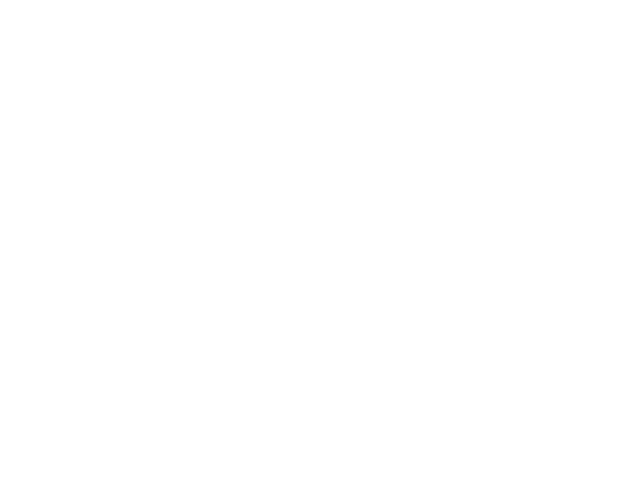

[35.781035157335566, 36.781035157335566, 37.781035157335566, 38.781035157335566, 39.781035157335566, 40.781035157335566]
[0.44209953728270357, 0.9524745795689005, 2.052044275596773, 4.420995372827034, 9.524745795689004, 20.52044275596773]
(array([  16,  601,  669,  808, 1999, 3025, 3258, 4284]),)


In [27]:
%matplotlib nbagg
plt.plot(dlll2[(dlll2 > 0) & (med/flux_max < j)], lumi[(dlll2 > 0) & (med/flux_max < j)], '.', c='k',  label='All Sources')
plt.plot(dlll2[(dlll2 > 0) & (med > 2e-17) & (med/flux_max < j)], lumi[(dlll2 > 0) & (med > 2e-17) & (med/flux_max < j)], '.', c='orange', label=r'$\mathrm{F_{DIG} > 2\times10^{-17}\,[erg\,\,s^{-1}\,\,cm^{-2}]}$')
#plt.plot(dlll[(dlll > 0) & (med < 2e-18)], lumi[(dlll > 0) & (med < 2e-18)], '.', c='r')
plt.plot(dlll2[(dlll2 > 0) & (lumi < 35.65)], lumi[(dlll2 > 0) & (lumi < 35.65)], '.', c='grey')
#plt.plot([150,87,65,46,38,30,26,20.3,0],\
#         [38.12,37.87,37.6,37.34,37.07,36.77,36.30,35.80,34.5])
#plt.plot([156,129,104,86,69,55,38,26,8.8],\
#         [38.12,37.87,37.6,37.34,37.07,36.77,36.30,35.80,34.38]) # 7500 K, ne = np = 1 cm-3
#plt.plot([1.28*156,1.28*129,1.28*104,1.28*86,1.28*69,1.28*55,1.28*38,1.28*26,1.28*8.8],\
#         [38.12,37.87,37.6,37.34,37.07,36.77,36.30,35.80,34.38]) # 10000 K, ne = np = 1 cm-3
#plt.plot([46,40,35,30.6,25.9,21.4,16.8,12.4,0],\
#         [38.12,37.87,37.6,37.34,37.07,36.77,36.30,35.80,34.38]) # 10000 K, ne = np = 10 cm-3
#plt.plot([46/1.28,40/1.28,35/1.28,30.6/1.28,25.9/1.28,21.4/1.28,16.8/1.28,12.4/1.28,0],\
#         [38.12,37.87,37.6,37.34,37.07,36.77,36.30,35.80,34.38]) # 7500 K, ne = np = 10 cm-3
yk = [38.12,37.87,37.6,37.34,37.07,36.77,36.30,35.80,34.38]
yk22 = [10**46.44,10*10**46.44,100*10**46.44,1000*10**46.44,10000*10**46.44,100000*10**46.44]
xk22 = [10**46.44,10*10**46.44,100*10**46.44,1000*10**46.44,10000*10**46.44,100000*10**46.44]
xk33 = [10**46.44,10*10**46.44,100*10**46.44,1000*10**46.44,10000*10**46.44,100000*10**46.44]
xk44 = [10**46.44,10*10**46.44,100*10**46.44,1000*10**46.44,10000*10**46.44,100000*10**46.44]
xk = [1.28*156,1.28*129,1.28*104,1.28*86,1.28*69,1.28*55,1.28*38,1.28*26,1.28*8.8]
xk2 = [1.28*156,1.28*129,1.28*104,1.28*86,1.28*69,1.28*55,1.28*38,1.28*26,1.28*8.8]
xk3 = [1.28*156,1.28*129,1.28*104,1.28*86,1.28*69,1.28*55,1.28*38,1.28*26,1.28*8.8]
xk4 = [1.28*156,1.28*129,1.28*104,1.28*86,1.28*69,1.28*55,1.28*38,1.28*26,1.28*8.8]
for i in range(0,9):
    yk[i] = np.log10(10**yk[i])
    xk[i] = (((xk[i]*3.085678*10**18)**3/10000)**0.33)/(3.085678*10**18)
    xk2[i] = (((xk2[i]*3.085678*10**18)**3*10)**0.33)/(3.085678*10**18)
    xk3[i] = (((xk3[i]*3.085678*10**18)**3/10)**0.33)/(3.085678*10**18)
    xk4[i] = xk4[i]*1.87
for i in range(0,6):
        yk22[i] = np.log10(yk22[i]*2e-8/912)
        xk22[i] = (3* xk22[i] / (2.59e-13*4*3.14159*100**2))**(1/3.0) / 3.085678e18
        xk33[i] = (3* xk33[i] / (2.59e-13*4*3.14159*10**2))**(1/3.0) / 3.085678e18
        xk44[i] = (3* xk44[i] / (2.59e-13*4*3.14159*1**2))**(1/3.0) / 3.085678e18
print yk22
print xk22
#plt.plot([1.87*156,1.87*129,1.87*104,1.87*86,1.87*69,1.87*55,1.87*38,1.87*26,1.87*8.8],\
#         [38.12,37.87,37.6,37.34,37.07,36.77,36.30,35.80,34.38]) # 20000 K, ne = np = 1 cm-3
#plt.plot(xk22,yk22, linestyle='dashed') # 10000K, ne = np = 100 cm-3 for FMI and different mass
#plt.plot(xk33,yk22, linestyle='dashed') # 10000K, ne = np = 10 cm-3 for FMI and different mass
#plt.plot(xk44,yk22, linestyle='dashed') # 10000K, ne = np = 1 cm-3 for FMI and different mass
#plt.plot(xk,yk) # 10000K, ne = np = 100 cm-3
#plt.plot(xk2,yk) # 10000K, giant region ne = np = 100 cm-3, M_tot = 100000 Mstar
#plt.plot(xk3,yk) # 10000K, giant region ne = np = 10 cm-3, M_tot = 100000 Mstar
#plt.plot(xk4,yk) # 20000K, giant region ne = np = 10 cm-3, M_tot = 100000 Mstar
plt.ylabel('$\mathrm{log\,\,L\,\,[erg\,\,s^{-1}]}$', \
           fontname='Helvetica',fontsize=16)
plt.xlabel('$\mathrm{80\%\,\,Flux\,\,Radius\,\,[pc]}$', fontname='Helvetica',fontsize=16)
#plt.plot(r1,q-11.51, c='y', linestyle='dashed', linewidth=2) # 10000K, ne = np = 1 cm-3 for FMI and different mass
plt.plot(r10,q-11.86,c='g', linestyle='dashed', linewidth=2) # 10000K, ne = np = 10 cm-3 for FMI and different mass
plt.plot(r100,q-11.86, c='b',linestyle='dashed', linewidth=2) # 10000K, ne = np = 100 cm-3 for FMI and different mass
#plt.plot(r500,q-11.86, c='cyan',linestyle='dashed', linewidth=2) # 10000K, ne = np = 100 cm-3 for FMI and different mass
plt.plot(r10075,q-11.86, c=(0,0,0.4),linestyle='dashed', linewidth=2) # 10000K, ne = np = 100 cm-3 for FMI and different mass
#plt.plot(r10050,q-11.51, c=(0,0,0.8),linestyle='dashed', linewidth=2) # 10000K, ne = np = 100 cm-3 for FMI and different mass
#plt.plot(r10020,q-11.51, c=(0,0,0.6),linestyle='dashed', linewidth=2) # 10000K, ne = np = 100 cm-3 for FMI and different mass
plt.plot(r1000,q-11.86, c='r', linestyle='dashed', linewidth=2) # 10000K, ne = np = 1000 cm-3 for FMI and different mass
plt.axhline(35.65, color='k', linestyle='--')
#plt.plot(r100db,q-11.86, c='purple', linestyle='dashed', linewidth=2) # 10000K, ne = np = 100 cm-3 for FMI and different mass, density bounded
plt.axhline(35.65, color='k', linestyle='--')
#print np.where(dlll[(np.where(dlll > 0))] < 10)
#plt.plot(dlll/lim, flux_tot, '.b')
plt.xlim(0,200)
plt.ylim(34.5,40)
plt.show()
print np.where(dlll > 140)
#plt.annotate('$\mathrm{T_e = 10\,000^\degree K, n_e = 1\,cm^{-3}}$',xy=(0.68,0.05),xycoords='axes fraction',\
#            fontsize=12.0, color='y')
plt.annotate('$\mathrm{T_e = 10\,000^\degree K, n_e = 10\,cm^{-3}}$',xy=(0.67,0.365),xycoords='axes fraction',\
            fontsize=12.0, color='g')
plt.annotate('$\mathrm{T_e = 10\,000^\degree K, n_e = 100\,cm^{-3}}$',xy=(0.65,0.725),xycoords='axes fraction',\
            fontsize=12.0, color='b')
plt.annotate('$\mathrm{T_e = 7\,500^\degree K, n_e = 100\,cm^{-3}}$',xy=(0.52,0.85),xycoords='axes fraction',\
            fontsize=12.0, color=(0,0,0.4))
plt.annotate('$\mathrm{T_e = 10\,000^\degree K, n_e = 1000\,cm^{-3}}$',xy=(0.38,0.95),xycoords='axes fraction',\
            fontsize=12.0, color='r')
plt.annotate('$\mathrm{Completeness\,\,Threshold}$',xy=(0.75,0.22),xycoords='axes fraction',\
            fontsize=10.0, color='k')
plt.legend(loc='lower right',fontsize=12)


In [418]:
#Save the Plot in a .eps or .png file
plt.savefig('NGC628_region_lumi_FWHM_80.eps')
#plt.savefig('test.png', dpi=1000)

In [28]:
def find_nearest(array,value):
    idx = np.searchsorted(array, value, side="left")
    if idx > 0 and (idx == len(array) or math.fabs(value - array[idx-1]) < math.fabs(value - array[idx])):
        return array[idx-1]
    else:
        return idx

In [31]:
fonction = fits.getdata('flux_80_3_size.fits')
r = np.arange(300)
dlll3 = deepcopy(dlll2)
dlll4 = deepcopy(dlll2)
dlll4[(dlll4 > 300)] = 299
for i in range(0,4285):
    
    dlll3[i] = find_nearest(fonction,round(dlll4[i]))
print dlll3

[  98.   98.   94. ...,  174.   94.  251.]


In [ ]:
print np.where((lumi > 36) & (dlll2 > 150) & (med/flux_max < j))

570


<IPython.core.display.Javascript object>


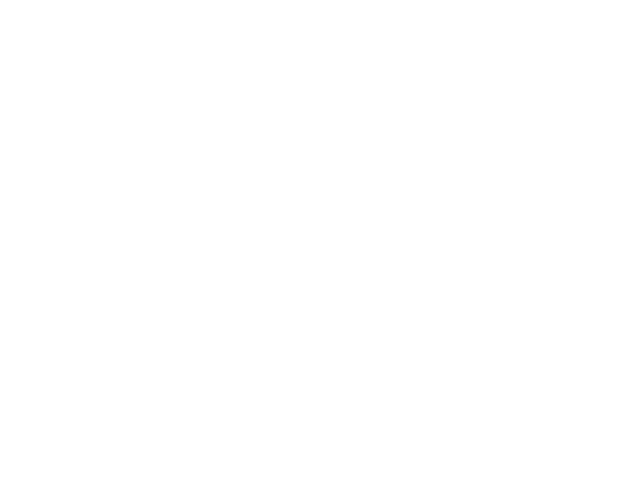

In [29]:
%matplotlib nbagg
#for i in range(0,len(regx)) :

name = 'Test'
i=2115

dist = np.array(len(np.where(grow == i+1)[0]))
flux_prof = np.array(len(np.where(grow == i+1)[0]))
print len(np.where(grow == i+1)[0]) # number of pixels

xxyy=np.where(grow == i+1)
dist=d[xxyy[0],xxyy[1]]
flux_prof=flux[xxyy[0],xxyy[1]]

max = np.mean(flux_prof[(dist == np.min(dist))])
plt.plot(dist,flux_prof/max,'.b')
plt.ylabel('$\mathrm{Flux_{normed}}$', fontname='Helvetica',fontsize=16)
plt.xlabel('$\mathrm{Distance\,\,[pc]}$', fontname='Helvetica',fontsize=16)
plt.annotate(name,xy=(0.8,0.9),xycoords='axes fraction',\
            fontsize=16.0, horizontalalignment='center',verticalalignment='bottom', \
             color='k', fontname='times', fontweight='bold')
plt.axhline(med[i]/max, color='k', linestyle='--')
plt.axvline(lim[i], color='k', linestyle='--')
plt.axvline(dlll2[i], color='k', linestyle='--')
plt.ylim(-0.5,2)
plt.show()

<IPython.core.display.Javascript object>


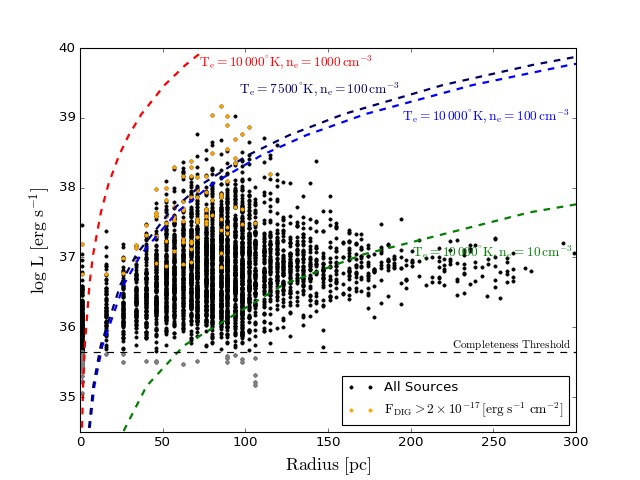

[35.781035157335566, 36.781035157335566, 37.781035157335566, 38.781035157335566, 39.781035157335566, 40.781035157335566]
[0.44209953728270357, 0.9524745795689005, 2.052044275596773, 4.420995372827034, 9.524745795689004, 20.52044275596773]
(array([  16,  601,  669,  808, 1999, 3025, 3258, 4284]),)


In [32]:
%matplotlib nbagg
plt.plot(dlll3[(dlll3 > 0) & (med/flux_max < j)], lumi[(dlll3 > 0) & (med/flux_max < j)], '.', c='k',  label='All Sources')
plt.plot(dlll3[(dlll3 > 0) & (med > 2e-17) & (med/flux_max < j)], lumi[(dlll3 > 0) & (med > 2e-17) & (med/flux_max < j)], '.', c='orange', label=r'$\mathrm{F_{DIG} > 2\times10^{-17}\,[erg\,\,s^{-1}\,\,cm^{-2}]}$')
#plt.plot(dlll[(dlll > 0) & (med < 2e-18)], lumi[(dlll > 0) & (med < 2e-18)], '.', c='r')
plt.plot(dlll3[(dlll3 > 0) & (lumi < 35.65)], lumi[(dlll3 > 0) & (lumi < 35.65)], '.', c='grey')
#plt.plot([150,87,65,46,38,30,26,20.3,0],\
#         [38.12,37.87,37.6,37.34,37.07,36.77,36.30,35.80,34.5])
#plt.plot([156,129,104,86,69,55,38,26,8.8],\
#         [38.12,37.87,37.6,37.34,37.07,36.77,36.30,35.80,34.38]) # 7500 K, ne = np = 1 cm-3
#plt.plot([1.28*156,1.28*129,1.28*104,1.28*86,1.28*69,1.28*55,1.28*38,1.28*26,1.28*8.8],\
#         [38.12,37.87,37.6,37.34,37.07,36.77,36.30,35.80,34.38]) # 10000 K, ne = np = 1 cm-3
#plt.plot([46,40,35,30.6,25.9,21.4,16.8,12.4,0],\
#         [38.12,37.87,37.6,37.34,37.07,36.77,36.30,35.80,34.38]) # 10000 K, ne = np = 10 cm-3
#plt.plot([46/1.28,40/1.28,35/1.28,30.6/1.28,25.9/1.28,21.4/1.28,16.8/1.28,12.4/1.28,0],\
#         [38.12,37.87,37.6,37.34,37.07,36.77,36.30,35.80,34.38]) # 7500 K, ne = np = 10 cm-3
yk = [38.12,37.87,37.6,37.34,37.07,36.77,36.30,35.80,34.38]
yk22 = [10**46.44,10*10**46.44,100*10**46.44,1000*10**46.44,10000*10**46.44,100000*10**46.44]
xk22 = [10**46.44,10*10**46.44,100*10**46.44,1000*10**46.44,10000*10**46.44,100000*10**46.44]
xk33 = [10**46.44,10*10**46.44,100*10**46.44,1000*10**46.44,10000*10**46.44,100000*10**46.44]
xk44 = [10**46.44,10*10**46.44,100*10**46.44,1000*10**46.44,10000*10**46.44,100000*10**46.44]
xk = [1.28*156,1.28*129,1.28*104,1.28*86,1.28*69,1.28*55,1.28*38,1.28*26,1.28*8.8]
xk2 = [1.28*156,1.28*129,1.28*104,1.28*86,1.28*69,1.28*55,1.28*38,1.28*26,1.28*8.8]
xk3 = [1.28*156,1.28*129,1.28*104,1.28*86,1.28*69,1.28*55,1.28*38,1.28*26,1.28*8.8]
xk4 = [1.28*156,1.28*129,1.28*104,1.28*86,1.28*69,1.28*55,1.28*38,1.28*26,1.28*8.8]
for i in range(0,9):
    yk[i] = np.log10(10**yk[i])
    xk[i] = (((xk[i]*3.085678*10**18)**3/10000)**0.33)/(3.085678*10**18)
    xk2[i] = (((xk2[i]*3.085678*10**18)**3*10)**0.33)/(3.085678*10**18)
    xk3[i] = (((xk3[i]*3.085678*10**18)**3/10)**0.33)/(3.085678*10**18)
    xk4[i] = xk4[i]*1.87
for i in range(0,6):
        yk22[i] = np.log10(yk22[i]*2e-8/912)
        xk22[i] = (3* xk22[i] / (2.59e-13*4*3.14159*100**2))**(1/3.0) / 3.085678e18
        xk33[i] = (3* xk33[i] / (2.59e-13*4*3.14159*10**2))**(1/3.0) / 3.085678e18
        xk44[i] = (3* xk44[i] / (2.59e-13*4*3.14159*1**2))**(1/3.0) / 3.085678e18
print yk22
print xk22
#plt.plot([1.87*156,1.87*129,1.87*104,1.87*86,1.87*69,1.87*55,1.87*38,1.87*26,1.87*8.8],\
#         [38.12,37.87,37.6,37.34,37.07,36.77,36.30,35.80,34.38]) # 20000 K, ne = np = 1 cm-3
#plt.plot(xk22,yk22, linestyle='dashed') # 10000K, ne = np = 100 cm-3 for FMI and different mass
#plt.plot(xk33,yk22, linestyle='dashed') # 10000K, ne = np = 10 cm-3 for FMI and different mass
#plt.plot(xk44,yk22, linestyle='dashed') # 10000K, ne = np = 1 cm-3 for FMI and different mass
#plt.plot(xk,yk) # 10000K, ne = np = 100 cm-3
#plt.plot(xk2,yk) # 10000K, giant region ne = np = 100 cm-3, M_tot = 100000 Mstar
#plt.plot(xk3,yk) # 10000K, giant region ne = np = 10 cm-3, M_tot = 100000 Mstar
#plt.plot(xk4,yk) # 20000K, giant region ne = np = 10 cm-3, M_tot = 100000 Mstar
plt.ylabel('$\mathrm{log\,\,L\,\,[erg\,\,s^{-1}]}$', \
           fontname='Helvetica',fontsize=16)
plt.xlabel('$\mathrm{Radius\,\,[pc]}$', fontname='Helvetica',fontsize=16)
#plt.plot(r1,q-11.51, c='y', linestyle='dashed', linewidth=2) # 10000K, ne = np = 1 cm-3 for FMI and different mass
plt.plot(r10,q-11.86,c='g', linestyle='dashed', linewidth=2) # 10000K, ne = np = 10 cm-3 for FMI and different mass
plt.plot(r100,q-11.86, c='b',linestyle='dashed', linewidth=2) # 10000K, ne = np = 100 cm-3 for FMI and different mass
#plt.plot(r500,q-11.86, c='cyan',linestyle='dashed', linewidth=2) # 10000K, ne = np = 100 cm-3 for FMI and different mass
plt.plot(r10075,q-11.86, c=(0,0,0.4),linestyle='dashed', linewidth=2) # 10000K, ne = np = 100 cm-3 for FMI and different mass
#plt.plot(r10050,q-11.51, c=(0,0,0.8),linestyle='dashed', linewidth=2) # 10000K, ne = np = 100 cm-3 for FMI and different mass
#plt.plot(r10020,q-11.51, c=(0,0,0.6),linestyle='dashed', linewidth=2) # 10000K, ne = np = 100 cm-3 for FMI and different mass
plt.plot(r1000,q-11.86, c='r', linestyle='dashed', linewidth=2) # 10000K, ne = np = 1000 cm-3 for FMI and different mass
plt.axhline(35.65, color='k', linestyle='--')
#plt.plot(r100db,q-11.86, c='purple', linestyle='dashed', linewidth=2) # 10000K, ne = np = 100 cm-3 for FMI and different mass, density bounded
plt.axhline(35.65, color='k', linestyle='--')
#print np.where(dlll[(np.where(dlll > 0))] < 10)
#plt.plot(dlll/lim, flux_tot, '.b')
plt.xlim(0,300)
plt.ylim(34.5,40)
plt.show()
print np.where(dlll > 140)
#plt.annotate('$\mathrm{T_e = 10\,000^\degree K, n_e = 1\,cm^{-3}}$',xy=(0.68,0.05),xycoords='axes fraction',\
#            fontsize=12.0, color='y')
plt.annotate('$\mathrm{T_e = 10\,000^\degree K, n_e = 10\,cm^{-3}}$',xy=(0.67,0.455),xycoords='axes fraction',\
            fontsize=12.0, color='g')
plt.annotate('$\mathrm{T_e = 10\,000^\degree K, n_e = 100\,cm^{-3}}$',xy=(0.65,0.81),xycoords='axes fraction',\
            fontsize=12.0, color='b')
plt.annotate('$\mathrm{T_e = 7\,500^\degree K, n_e = 100\,cm^{-3}}$',xy=(0.32,0.88),xycoords='axes fraction',\
            fontsize=12.0, color=(0,0,0.4))
plt.annotate('$\mathrm{T_e = 10\,000^\degree K, n_e = 1000\,cm^{-3}}$',xy=(0.24,0.95),xycoords='axes fraction',\
            fontsize=12.0, color='r')
plt.annotate('$\mathrm{Completeness\,\,Threshold}$',xy=(0.75,0.22),xycoords='axes fraction',\
            fontsize=10.0, color='k')
plt.legend(loc='lower right',fontsize=12)


In [421]:
#Save the Plot in a .eps or .png file
plt.savefig('NGC628_region_lumi_FWHM_80_corr_3.eps')
#plt.savefig('test.png', dpi=1000)

In [33]:
fonction = fits.getdata('flux_80_2_size.fits')
r = np.arange(300)
dlll3 = deepcopy(dlll2)
dlll4 = deepcopy(dlll2)
dlll4[(dlll4 > 300)] = 299
for i in range(0,4285):
    
    dlll3[i] = find_nearest(fonction,round(dlll4[i]))
print dlll3

[ 105.  105.  101. ...,  178.  101.  253.]


<IPython.core.display.Javascript object>


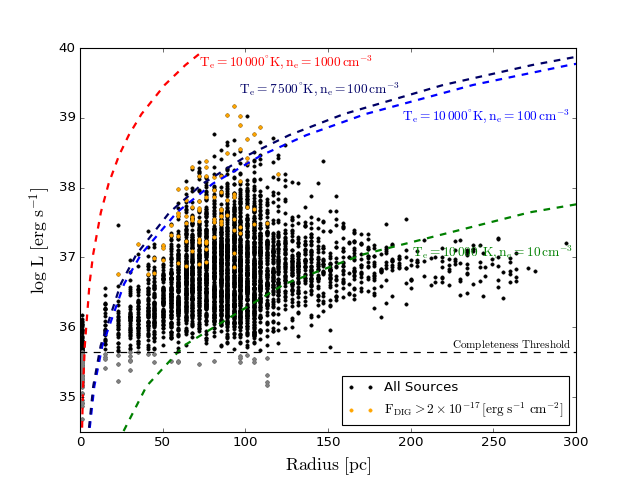

[35.781035157335566, 36.781035157335566, 37.781035157335566, 38.781035157335566, 39.781035157335566, 40.781035157335566]
[0.44209953728270357, 0.9524745795689005, 2.052044275596773, 4.420995372827034, 9.524745795689004, 20.52044275596773]
(array([  16,  601,  669,  808, 1999, 3025, 3258, 4284]),)


In [34]:
%matplotlib nbagg
plt.plot(dlll3[(dlll3 > 0) & (med/flux_max < j)], lumi[(dlll3 > 0) & (med/flux_max < j)], '.', c='k',  label='All Sources')
plt.plot(dlll3[(dlll3 > 0) & (med > 2e-17) & (med/flux_max < j)], lumi[(dlll3 > 0) & (med > 2e-17) & (med/flux_max < j)], '.', c='orange', label=r'$\mathrm{F_{DIG} > 2\times10^{-17}\,[erg\,\,s^{-1}\,\,cm^{-2}]}$')
#plt.plot(dlll[(dlll > 0) & (med < 2e-18)], lumi[(dlll > 0) & (med < 2e-18)], '.', c='r')
plt.plot(dlll3[(dlll3 > 0) & (lumi < 35.65)], lumi[(dlll3 > 0) & (lumi < 35.65)], '.', c='grey')
#plt.plot([150,87,65,46,38,30,26,20.3,0],\
#         [38.12,37.87,37.6,37.34,37.07,36.77,36.30,35.80,34.5])
#plt.plot([156,129,104,86,69,55,38,26,8.8],\
#         [38.12,37.87,37.6,37.34,37.07,36.77,36.30,35.80,34.38]) # 7500 K, ne = np = 1 cm-3
#plt.plot([1.28*156,1.28*129,1.28*104,1.28*86,1.28*69,1.28*55,1.28*38,1.28*26,1.28*8.8],\
#         [38.12,37.87,37.6,37.34,37.07,36.77,36.30,35.80,34.38]) # 10000 K, ne = np = 1 cm-3
#plt.plot([46,40,35,30.6,25.9,21.4,16.8,12.4,0],\
#         [38.12,37.87,37.6,37.34,37.07,36.77,36.30,35.80,34.38]) # 10000 K, ne = np = 10 cm-3
#plt.plot([46/1.28,40/1.28,35/1.28,30.6/1.28,25.9/1.28,21.4/1.28,16.8/1.28,12.4/1.28,0],\
#         [38.12,37.87,37.6,37.34,37.07,36.77,36.30,35.80,34.38]) # 7500 K, ne = np = 10 cm-3
yk = [38.12,37.87,37.6,37.34,37.07,36.77,36.30,35.80,34.38]
yk22 = [10**46.44,10*10**46.44,100*10**46.44,1000*10**46.44,10000*10**46.44,100000*10**46.44]
xk22 = [10**46.44,10*10**46.44,100*10**46.44,1000*10**46.44,10000*10**46.44,100000*10**46.44]
xk33 = [10**46.44,10*10**46.44,100*10**46.44,1000*10**46.44,10000*10**46.44,100000*10**46.44]
xk44 = [10**46.44,10*10**46.44,100*10**46.44,1000*10**46.44,10000*10**46.44,100000*10**46.44]
xk = [1.28*156,1.28*129,1.28*104,1.28*86,1.28*69,1.28*55,1.28*38,1.28*26,1.28*8.8]
xk2 = [1.28*156,1.28*129,1.28*104,1.28*86,1.28*69,1.28*55,1.28*38,1.28*26,1.28*8.8]
xk3 = [1.28*156,1.28*129,1.28*104,1.28*86,1.28*69,1.28*55,1.28*38,1.28*26,1.28*8.8]
xk4 = [1.28*156,1.28*129,1.28*104,1.28*86,1.28*69,1.28*55,1.28*38,1.28*26,1.28*8.8]
for i in range(0,9):
    yk[i] = np.log10(10**yk[i])
    xk[i] = (((xk[i]*3.085678*10**18)**3/10000)**0.33)/(3.085678*10**18)
    xk2[i] = (((xk2[i]*3.085678*10**18)**3*10)**0.33)/(3.085678*10**18)
    xk3[i] = (((xk3[i]*3.085678*10**18)**3/10)**0.33)/(3.085678*10**18)
    xk4[i] = xk4[i]*1.87
for i in range(0,6):
        yk22[i] = np.log10(yk22[i]*2e-8/912)
        xk22[i] = (3* xk22[i] / (2.59e-13*4*3.14159*100**2))**(1/3.0) / 3.085678e18
        xk33[i] = (3* xk33[i] / (2.59e-13*4*3.14159*10**2))**(1/3.0) / 3.085678e18
        xk44[i] = (3* xk44[i] / (2.59e-13*4*3.14159*1**2))**(1/3.0) / 3.085678e18
print yk22
print xk22
#plt.plot([1.87*156,1.87*129,1.87*104,1.87*86,1.87*69,1.87*55,1.87*38,1.87*26,1.87*8.8],\
#         [38.12,37.87,37.6,37.34,37.07,36.77,36.30,35.80,34.38]) # 20000 K, ne = np = 1 cm-3
#plt.plot(xk22,yk22, linestyle='dashed') # 10000K, ne = np = 100 cm-3 for FMI and different mass
#plt.plot(xk33,yk22, linestyle='dashed') # 10000K, ne = np = 10 cm-3 for FMI and different mass
#plt.plot(xk44,yk22, linestyle='dashed') # 10000K, ne = np = 1 cm-3 for FMI and different mass
#plt.plot(xk,yk) # 10000K, ne = np = 100 cm-3
#plt.plot(xk2,yk) # 10000K, giant region ne = np = 100 cm-3, M_tot = 100000 Mstar
#plt.plot(xk3,yk) # 10000K, giant region ne = np = 10 cm-3, M_tot = 100000 Mstar
#plt.plot(xk4,yk) # 20000K, giant region ne = np = 10 cm-3, M_tot = 100000 Mstar
plt.ylabel('$\mathrm{log\,\,L\,\,[erg\,\,s^{-1}]}$', \
           fontname='Helvetica',fontsize=16)
plt.xlabel('$\mathrm{Radius\,\,[pc]}$', fontname='Helvetica',fontsize=16)
#plt.plot(r1,q-11.51, c='y', linestyle='dashed', linewidth=2) # 10000K, ne = np = 1 cm-3 for FMI and different mass
plt.plot(r10,q-11.86,c='g', linestyle='dashed', linewidth=2) # 10000K, ne = np = 10 cm-3 for FMI and different mass
plt.plot(r100,q-11.86, c='b',linestyle='dashed', linewidth=2) # 10000K, ne = np = 100 cm-3 for FMI and different mass
#plt.plot(r500,q-11.86, c='cyan',linestyle='dashed', linewidth=2) # 10000K, ne = np = 100 cm-3 for FMI and different mass
plt.plot(r10075,q-11.86, c=(0,0,0.4),linestyle='dashed', linewidth=2) # 10000K, ne = np = 100 cm-3 for FMI and different mass
#plt.plot(r10050,q-11.51, c=(0,0,0.8),linestyle='dashed', linewidth=2) # 10000K, ne = np = 100 cm-3 for FMI and different mass
#plt.plot(r10020,q-11.51, c=(0,0,0.6),linestyle='dashed', linewidth=2) # 10000K, ne = np = 100 cm-3 for FMI and different mass
plt.plot(r1000,q-11.86, c='r', linestyle='dashed', linewidth=2) # 10000K, ne = np = 1000 cm-3 for FMI and different mass
plt.axhline(35.65, color='k', linestyle='--')
#plt.plot(r100db,q-11.86, c='purple', linestyle='dashed', linewidth=2) # 10000K, ne = np = 100 cm-3 for FMI and different mass, density bounded
plt.axhline(35.65, color='k', linestyle='--')
#print np.where(dlll[(np.where(dlll > 0))] < 10)
#plt.plot(dlll/lim, flux_tot, '.b')
plt.xlim(0,300)
plt.ylim(34.5,40)
plt.show()
print np.where(dlll > 140)
#plt.annotate('$\mathrm{T_e = 10\,000^\degree K, n_e = 1\,cm^{-3}}$',xy=(0.68,0.05),xycoords='axes fraction',\
#            fontsize=12.0, color='y')
plt.annotate('$\mathrm{T_e = 10\,000^\degree K, n_e = 10\,cm^{-3}}$',xy=(0.67,0.455),xycoords='axes fraction',\
            fontsize=12.0, color='g')
plt.annotate('$\mathrm{T_e = 10\,000^\degree K, n_e = 100\,cm^{-3}}$',xy=(0.65,0.81),xycoords='axes fraction',\
            fontsize=12.0, color='b')
plt.annotate('$\mathrm{T_e = 7\,500^\degree K, n_e = 100\,cm^{-3}}$',xy=(0.32,0.88),xycoords='axes fraction',\
            fontsize=12.0, color=(0,0,0.4))
plt.annotate('$\mathrm{T_e = 10\,000^\degree K, n_e = 1000\,cm^{-3}}$',xy=(0.24,0.95),xycoords='axes fraction',\
            fontsize=12.0, color='r')
plt.annotate('$\mathrm{Completeness\,\,Threshold}$',xy=(0.75,0.22),xycoords='axes fraction',\
            fontsize=10.0, color='k')
plt.legend(loc='lower right',fontsize=12)


In [424]:
#Save the Plot in a .eps or .png file
plt.savefig('NGC628_region_lumi_FWHM_80_corr.eps')
#plt.savefig('test.png', dpi=1000)

In [268]:
curve_fit?

In [ ]:
mod = PseudoVoigtModel()
a = np.zeros(4285)
cent = np.zeros(4285)
sig = np.zeros(4285)
fwhm = np.zeros(4285)
frac = np.zeros(4285)
amp = np.zeros(4285)

for i in range(0,4285):
    
    mod.set_param_hint('sigma', value=60, min=10, max=300)
    mod.set_param_hint('center', value=0, vary=0)
    mod.set_param_hint('fraction', value=0.5, min=0, max=1)
    mod.set_param_hint('fwhm', value=20)
    dist = np.array(len(np.where(grow == i+1)[0]))
    flux_prof = np.array(len(np.where(grow == i+1)[0]))
    xxyy = np.where(grow == i+1)
    dist = d[xxyy[0],xxyy[1]]
    flux_prof = flux2[xxyy[0],xxyy[1]]
    maxi = np.mean(flux_prof[(dist < np.min(dist)+5)])
    
    xx = np.where((flux_prof/maxi > 0.6) & (dist > 100)) 
    flux_prof[xx] = -10
    xx = np.where((flux_prof/maxi > 1.2) & (dist > 10)) 
    flux_prof[xx] = -10

    x = dist[(flux_prof > -9) & (dist < lim[i]+50)]
    y = flux_prof[(flux_prof > -9) & (dist < lim[i]+50)]-med2[i]

    mod.set_param_hint('amplitude', value = maxi*100, min=maxi*10)
    pars = mod.make_params()
    out = mod.fit(y, pars, x=x, method='nelder', fit_kws={'nan_policy': 'omit'})
    params = out.params

    a[i] = params['amplitude']
    cent[i] = params['center']
    sig[i] = params['sigma']
    frac[i] = params['fraction']
    fwhm[i] = params['fwhm']
    amp[i] = ((1-frac[i])*a[i]*np.exp(-(0)**2/(2*(sig[i]/(2*np.log(2))**0.5)**2))/((sig[i]/(2*np.log(2))**0.5)*(2*np.pi)**0.5)+frac[i]*a[i]*sig[i]/(sig[i]**2))    
    
    
    if sig[i] > 200:
        
        x = dist[(flux_prof > 0) & (dist < 100)]
        y = flux_prof[(flux_prof > 0) & (dist < 100)]-med2[i]
        
        out = mod.fit(y, pars, x=x, method='nelder', fit_kws={'nan_policy': 'omit'})
        params = out.params
    
        a[i] = params['amplitude']
        cent[i] = params['center']
        sig[i] = params['sigma']
        frac[i] = params['fraction']
        fwhm[i] = params['fwhm']
        amp[i] = ((1-frac[i])*a[i]*np.exp(-(0)**2/(2*(sig[i]/(2*np.log(2))**0.5)**2))/((sig[i]/(2*np.log(2))**0.5)*(2*np.pi)**0.5)+frac[i]*a[i]*sig[i]/(sig[i]**2))
    
    if sig[i] > 200:
        
        x = dist[(flux_prof > 0) & (dist < 50)]
        y = flux_prof[(flux_prof > 0) & (dist < 50)]-med2[i]
        
        out = mod.fit(y, pars, x=x, method='nelder', fit_kws={'nan_policy': 'omit'})
        params = out.params
    
        a[i] = params['amplitude']
        cent[i] = params['center']
        sig[i] = params['sigma']
        frac[i] = params['fraction']
        fwhm[i] = params['fwhm']
        amp[i] = ((1-frac[i])*a[i]*np.exp(-(0)**2/(2*(sig[i]/(2*np.log(2))**0.5)**2))/((sig[i]/(2*np.log(2))**0.5)*(2*np.pi)**0.5)+frac[i]*a[i]*sig[i]/(sig[i]**2))



In [ ]:
fits.writeto('NGC628_voigt_amplitude.fits',a)
fits.writeto('NGC628_voigt_sigma.fits',sig)
fits.writeto('NGC628_voigt_fraction.fits', frac)
fits.writeto('NGC628_voigt_I0.fits', amp)


In [ ]:
%matplotlib nbagg
j=0.4
jj=1.5e-17
plt.plot(sig[(sig > 0) & (med2/flux_max2 < j)], lumi2[(sig > 0) & (med2/flux_max2 < j)], '.', c='k',  label='All Sources')
plt.plot(sig[(sig > 0) & (med2 > jj) & (med2/flux_max2 < j) & (lumi2 > 35.65)], lumi2[(sig > 0) & (med2 > jj) & (med2/flux_max2 < j) & (lumi2 > 35.65)], '.', c='orange', label=r'$\mathrm{F_{DIG} > 1.5\times10^{-17}\,[erg\,\,s^{-1}\,\,cm^{-2}]}$')
plt.plot(sig[(lumi2 < 35.65)], lumi2[(lumi2 < 35.65)], '.', c='grey')
#plt.plot(sig[(frac > 0.75)], lumi2[(frac > 0.75)], '.', c='r')
#plt.plot(sig[(frac < 0.2)], lumi2[(frac < 0.2)], '.', c='r')
#plt.plot([150,87,65,46,38,30,26,20.3,0],\
#         [38.12,37.87,37.6,37.34,37.07,36.77,36.30,35.80,34.5])
#plt.plot([156,129,104,86,69,55,38,26,8.8],\
#         [38.12,37.87,37.6,37.34,37.07,36.77,36.30,35.80,34.38]) # 7500 K, ne = np = 1 cm-3
#plt.plot([1.28*156,1.28*129,1.28*104,1.28*86,1.28*69,1.28*55,1.28*38,1.28*26,1.28*8.8],\
#         [38.12,37.87,37.6,37.34,37.07,36.77,36.30,35.80,34.38]) # 10000 K, ne = np = 1 cm-3
#plt.plot([46,40,35,30.6,25.9,21.4,16.8,12.4,0],\
#         [38.12,37.87,37.6,37.34,37.07,36.77,36.30,35.80,34.38]) # 10000 K, ne = np = 10 cm-3
#plt.plot([46/1.28,40/1.28,35/1.28,30.6/1.28,25.9/1.28,21.4/1.28,16.8/1.28,12.4/1.28,0],\
#         [38.12,37.87,37.6,37.34,37.07,36.77,36.30,35.80,34.38]) # 7500 K, ne = np = 10 cm-3
yk = [38.12,37.87,37.6,37.34,37.07,36.77,36.30,35.80,34.38]
yk22 = [10**46.44,10*10**46.44,100*10**46.44,1000*10**46.44,10000*10**46.44,100000*10**46.44]
xk22 = [10**46.44,10*10**46.44,100*10**46.44,1000*10**46.44,10000*10**46.44,100000*10**46.44]
xk33 = [10**46.44,10*10**46.44,100*10**46.44,1000*10**46.44,10000*10**46.44,100000*10**46.44]
xk44 = [10**46.44,10*10**46.44,100*10**46.44,1000*10**46.44,10000*10**46.44,100000*10**46.44]
xk = [1.28*156,1.28*129,1.28*104,1.28*86,1.28*69,1.28*55,1.28*38,1.28*26,1.28*8.8]
xk2 = [1.28*156,1.28*129,1.28*104,1.28*86,1.28*69,1.28*55,1.28*38,1.28*26,1.28*8.8]
xk3 = [1.28*156,1.28*129,1.28*104,1.28*86,1.28*69,1.28*55,1.28*38,1.28*26,1.28*8.8]
xk4 = [1.28*156,1.28*129,1.28*104,1.28*86,1.28*69,1.28*55,1.28*38,1.28*26,1.28*8.8]
for i in range(0,9):
    yk[i] = np.log10(10**yk[i])
    xk[i] = (((xk[i]*3.085678*10**18)**3/10000)**0.33)/(3.085678*10**18)
    xk2[i] = (((xk2[i]*3.085678*10**18)**3*10)**0.33)/(3.085678*10**18)
    xk3[i] = (((xk3[i]*3.085678*10**18)**3/10)**0.33)/(3.085678*10**18)
    xk4[i] = xk4[i]*1.87
for i in range(0,6):
        yk22[i] = np.log10(yk22[i]*2e-8/912)
        xk22[i] = (3* xk22[i] / (2.59e-13*4*3.14159*100**2))**(1/3.0) / 3.085678e18
        xk33[i] = (3* xk33[i] / (2.59e-13*4*3.14159*10**2))**(1/3.0) / 3.085678e18
        xk44[i] = (3* xk44[i] / (2.59e-13*4*3.14159*1**2))**(1/3.0) / 3.085678e18
print yk22
print xk22
#plt.plot([1.87*156,1.87*129,1.87*104,1.87*86,1.87*69,1.87*55,1.87*38,1.87*26,1.87*8.8],\
#         [38.12,37.87,37.6,37.34,37.07,36.77,36.30,35.80,34.38]) # 20000 K, ne = np = 1 cm-3
#plt.plot(xk22,yk22, linestyle='dashed') # 10000K, ne = np = 100 cm-3 for FMI and different mass
#plt.plot(xk33,yk22, linestyle='dashed') # 10000K, ne = np = 10 cm-3 for FMI and different mass
#plt.plot(xk44,yk22, linestyle='dashed') # 10000K, ne = np = 1 cm-3 for FMI and different mass
#plt.plot(xk,yk) # 10000K, ne = np = 100 cm-3
#plt.plot(xk2,yk) # 10000K, giant region ne = np = 100 cm-3, M_tot = 100000 Mstar
#plt.plot(xk3,yk) # 10000K, giant region ne = np = 10 cm-3, M_tot = 100000 Mstar
#plt.plot(xk4,yk) # 20000K, giant region ne = np = 10 cm-3, M_tot = 100000 Mstar
plt.ylabel('$\mathrm{log\,\,L\,\,[erg\,\,s^{-1}]}$', \
           fontname='Helvetica',fontsize=16)
plt.xlabel('$\mathrm{Radius\,\,[pc]}$', fontname='Helvetica',fontsize=16)
#plt.plot(r1,q-11.51, c='y', linestyle='dashed', linewidth=2) # 10000K, ne = np = 1 cm-3 for FMI and different mass
plt.plot(r10,q-11.86,c='g', linestyle='dashed', linewidth=2) # 10000K, ne = np = 10 cm-3 for FMI and different mass
plt.plot(r100,q-11.86, c='b',linestyle='dashed', linewidth=2) # 10000K, ne = np = 100 cm-3 for FMI and different mass
#plt.plot(r500,q-11.86, c='cyan',linestyle='dashed', linewidth=2) # 10000K, ne = np = 100 cm-3 for FMI and different mass
plt.plot(r10075,q-11.86, c=(0,0,0.4),linestyle='dashed', linewidth=2) # 10000K, ne = np = 100 cm-3 for FMI and different mass
#plt.plot(r10050,q-11.51, c=(0,0,0.8),linestyle='dashed', linewidth=2) # 10000K, ne = np = 100 cm-3 for FMI and different mass
#plt.plot(r10020,q-11.51, c=(0,0,0.6),linestyle='dashed', linewidth=2) # 10000K, ne = np = 100 cm-3 for FMI and different mass
plt.plot(r1000,q-11.86, c='r', linestyle='dashed', linewidth=2) # 10000K, ne = np = 1000 cm-3 for FMI and different mass
plt.axhline(35.65, color='k', linestyle='--')
#plt.plot(r100db,q-11.86, c='purple', linestyle='dashed', linewidth=2) # 10000K, ne = np = 100 cm-3 for FMI and different mass, density bounded
plt.axhline(35.65, color='k', linestyle='--')
#print np.where(dlll[(np.where(dlll > 0))] < 10)
#plt.plot(dlll/lim, flux_tot, '.b')
plt.xlim(0,300)
plt.ylim(34.5,40)
plt.show()
#plt.annotate('$\mathrm{T_e = 10\,000^\degree K, n_e = 1\,cm^{-3}}$',xy=(0.68,0.05),xycoords='axes fraction',\
#            fontsize=12.0, color='y')
plt.annotate('$\mathrm{T_e = 10\,000^\degree K, n_e = 10\,cm^{-3}}$',xy=(0.67,0.455),xycoords='axes fraction',\
            fontsize=12.0, color='g')
plt.annotate('$\mathrm{T_e = 10\,000^\degree K, n_e = 100\,cm^{-3}}$',xy=(0.65,0.81),xycoords='axes fraction',\
            fontsize=12.0, color='b')
plt.annotate('$\mathrm{T_e = 7\,500^\degree K, n_e = 100\,cm^{-3}}$',xy=(0.32,0.88),xycoords='axes fraction',\
            fontsize=12.0, color=(0,0,0.4))
plt.annotate('$\mathrm{T_e = 10\,000^\degree K, n_e = 1000\,cm^{-3}}$',xy=(0.24,0.95),xycoords='axes fraction',\
            fontsize=12.0, color='r')
plt.annotate('$\mathrm{Completeness\,\,Threshold}$',xy=(0.75,0.22),xycoords='axes fraction',\
            fontsize=10.0, color='k')
plt.legend(loc='lower right',fontsize=12)


In [237]:
#Save the Plot in a .eps or .png file
plt.savefig('NGC628_region_lumi_SIG.eps', transparent=True, bbox_inches='tight', pad_inches=0.04)
#plt.savefig('test.png', dpi=1000)

In [ ]:
%matplotlib nbagg

i = 4158
dist = np.array(len(np.where(grow == i+1)[0]))
flux_prof = np.array(len(np.where(grow == i+1)[0]))
print len(np.where(grow == i+1)[0])# number of pixels

xxyy = np.where(grow == i+1)
dist = d[xxyy[0],xxyy[1]]
flux_prof = flux2[xxyy[0],xxyy[1]]
maxi = np.mean(flux_prof[(dist < np.min(dist)+5)])
print maxi

x2 = deepcopy(dist)
y2 = deepcopy(flux_prof)

xx = np.where((flux_prof/maxi > 0.6) & (dist > 100)) 
flux_prof[xx] = -10
xx = np.where((flux_prof/maxi > 1.2) & (dist > 10)) 
flux_prof[xx] = -10

x = dist[(flux_prof > -9) & (dist < lim[i]+50)]
y = flux_prof[(flux_prof > -9) & (dist < lim[i]+50)]-med2[i]
#print x
#print y

mod = PseudoVoigtModel()
mod.set_param_hint('amplitude', value = maxi*100, min=maxi*10)
mod.set_param_hint('sigma', value=10, min=10, max=300)
mod.set_param_hint('center', value=0, vary=0)
mod.set_param_hint('fraction', value=0.5, min=0, max=0.9)
mod.set_param_hint('fwhm', value=20)
pars = mod.make_params()
out = mod.fit(y, pars, x=x, method='nelder', fit_kws={'nan_policy': 'omit'})
params = out.params
#print mod.fit(y, pars, x=x)
#plt.plot(x,y,'.')
#plt.plot(np.arange(200),PseudoVoigtModel(1.35e-15,41,0,0.75,82.5), '.')
#plt.show

a2 = params['amplitude']
cent2 = params['center']
sig2 = params['sigma']
frac2 = params['fraction']
sigg2 = params['fwhm']
#print(out.fit_report(min_correl=0.25))

#print ( (1-frac2)*a2*np.exp(-(np.arange(1)-cent2)**2/(2*(sig2/(2*np.log(2))**0.5)**2))/((sig2/(2*np.log(2))**0.5)*(2*np.pi)**0.5)+\
#            frac2*a2*sig/(np.pi*((np.arange(1)-cent2)**2+sig2**2)),med2[i],sig2*1,frac2*1)
plt.plot(x2, y2, '.')
#plt.plot(x, out.init_fit+med[i], 'k--')
plt.plot(np.arange(lim[i]), ((1-frac2)*a2*np.exp(-(np.arange(lim[i])-cent2)**2/(2*(sig2/(2*np.log(2))**0.5)**2))/((sig2/(2*np.log(2))**0.5)*(2*np.pi)**0.5)+\
            frac2*a2*sig2/(np.pi*((np.arange(lim[i])-cent2)**2+sig2**2))+med2[i]), 'k-')
plt.plot(np.arange(lim[i]), ((1-frac[i])*a[i]*np.exp(-(np.arange(lim[i])-cent[i])**2/(2*(sig[i]/(2*np.log(2))**0.5)**2))/((sig[i]/(2*np.log(2))**0.5)*(2*np.pi)**0.5)+\
            frac[i]*a[i]*sig[i]/(np.pi*((np.arange(lim[i])-cent[i])**2+sig[i]**2))+med2[i]), 'r-')
plt.ylabel('$\mathrm{Flux\,\,[erg\,\,s^{-1}\,cm^{-2}]}$', fontname='Helvetica',fontsize=16)
plt.xlabel('$\mathrm{Distance\,\,[pc]}$', fontname='Helvetica',fontsize=16)
#plt.annotate('DIG Background',xy=(0.85,0.14),xycoords='axes fraction',\
#            fontsize=12.0, horizontalalignment='center',verticalalignment='bottom', \
#             color='k', fontname='times', fontweight='bold')
#plt.annotate('Outer Limit',xy=(0.52,0.735),xycoords='axes fraction',\
#            fontsize=12.0, horizontalalignment='center',verticalalignment='bottom', \
#             color='k', fontname='times', fontweight='bold', rotation=90)
plt.axhline(med2[i], color='r', linestyle='--')
plt.axhline(med[i], color='k', linestyle='--')
plt.axvline(lim[i], color='k', linestyle='--')
plt.ylim(-0.2*maxi,1.5*maxi)
plt.xlim(0,350)
plt.show()
print sig[i]
print frac[i]
print sig2
print frac2

In [ ]:
i=420
dist = np.array(len(np.where(grow == i+1)[0]))
flux_prof = np.array(len(np.where(grow == i+1)[0]))
print len(np.where(grow == i+1)[0])# number of pixels

xxyy = np.where(grow == i+1)
dist = d[xxyy[0],xxyy[1]]
flux_prof = flux2[xxyy[0],xxyy[1]]
maxi = np.mean(flux_prof[(dist < np.min(dist)+5)])
print maxi
print med[420]
print med2[420]
print flux[(grow == i+1) & (d > lim[i]-5) & (d < lim[i]+35)]
%matplotlib nbagg
plt.plot(dist, flux_prof, '.')
plt.show()